# Part 1. Gender Classification from audio files

The goal of this first part of the assignment is to perform a binary classification task to be able to predict the gender of a speaker. We will train different ML algorithms on OpenSLR's [LibriSpeech corpus](http://www.openslr.org/12/).\
LibriSpeech is a corpus of read speech, based on LibriVox's public domain audio books. Its purpose is to enable the training and testing of automatic speech recognition (ASR) systems. 

We will use the _dev-clean_ subset of the corpus, a development set containing "clean" speech, which consists of audio files of 40 speakers, labelled by gender.





## Imports

In [1]:
import datetime
import glob
import math
import os
import time

import fairseq
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import torch
import umap

from matplotlib.pyplot import figure
from python_speech_features import mfcc
from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from helpers import *

# Automatically reload modules
%load_ext autoreload
%autoreload 2

2023-02-21 22:50:47 | INFO | numexpr.utils | NumExpr defaulting to 4 threads.


## File paths and global variables

In [2]:
SPEAKERS_METADATA = "./LibriSpeech/SPEAKERS.TXT"
DEV_CLEAN = "./LibriSpeech/dev-clean/"

In [3]:
NUMCEP = 13  # number of cepstrum for MFCCs extraction
SPLIT_RATIO = 0.7  # train set split ratio
sns.set_theme(style="darkgrid")

## Load data

### Get ids and genres from metadata

Get information about speakers' gender and total amount of audio in the whole corpus.

In [4]:
speakers_gender = {}

with open(SPEAKERS_METADATA) as f:
    for line in f:
        if ";" not in line:
            speaker_id = int(line.split("|")[0])
            gender = line.split("|")[1].strip()
            speakers_gender[speaker_id] = 0 if gender == 'M' else 1
            
print(f"Total number of speakers in whole corpus:  {len(speakers_gender):>5,}")

Total number of speakers in whole corpus:  2,484


### Get ids and genres for "dev-clean" subset

In [5]:
# get all speakers ids in dev-clean subset of the corpus folder
speaker_ids = [int(speaker_dir) for speaker_dir in os.listdir(DEV_CLEAN) if not speaker_dir.startswith('.') ]
male_ids = [speaker_id for speaker_id in speaker_ids if speakers_gender[speaker_id] == 0]
female_ids = [speaker_id for speaker_id in speaker_ids if speakers_gender[speaker_id] == 1]

print(f"Number of speakers in dev-clean's subset:  {len(speaker_ids):>5,}")
print(f"• Number of male speakers:                 {len(male_ids):>5,}")
print(f"• Number of female speakers:               {len(female_ids):>5,}")

Number of speakers in dev-clean's subset:     40
• Number of male speakers:                    20
• Number of female speakers:                  20


## Build dataset

### Split speaker ids for train and test sets

We make sure we train our model with a balanced training set by adding the same amount of males and females in the training set.

Also, we make sure that speakers in the testing data are not in the training data (no overlap). This ensures that our algorithm is generalizing, and not merely memorizing speakers. 

In [6]:
print(f"Split train / test sets ({SPLIT_RATIO:.0%}/{1-SPLIT_RATIO:.0%}) for male and female speakers: ")
male_ids_train, male_ids_test = split_speakers(male_ids, SPLIT_RATIO, 42)
female_ids_train, female_ids_test = split_speakers(female_ids, SPLIT_RATIO, 42)

print(f"• Number of male ids for train set:   {len(male_ids_train):>3}")
print(f"• Number of female ids for train set: {len(female_ids_train):>3}")
print(f"• Number of male ids for test set:    {len(male_ids_test):>3}")
print(f"• Number of female ids for test set:  {len(female_ids_test):>3}")

Split train / test sets (70%/30%) for male and female speakers: 
• Number of male ids for train set:    14
• Number of female ids for train set:  14
• Number of male ids for test set:      6
• Number of female ids for test set:    6


### Extract MFCC features from audio files

In [7]:
print("Build train dataset: ")
train_dataset = build_dataset(male_ids_train + female_ids_train, speakers_gender, NUMCEP, DEV_CLEAN)
print(train_dataset.shape, "\n")

print("Build test dataset: ")
test_dataset = build_dataset(male_ids_test + female_ids_test, speakers_gender, NUMCEP, DEV_CLEAN)
print(test_dataset.shape, "\n")

Build train dataset: 


Extracting MFCCs:   0%|          | 0/28 [00:00<?, ?it/s]

Speaker 2078:  52 audio files, gender 0 (M)
Speaker  652:  71 audio files, gender 0 (M)
Speaker 2902:  38 audio files, gender 0 (M)
Speaker 3752: 101 audio files, gender 0 (M)
Speaker 7976:  78 audio files, gender 0 (M)
Speaker 5536:  59 audio files, gender 0 (M)
Speaker 5694:  83 audio files, gender 0 (M)
Speaker 3000:  47 audio files, gender 0 (M)
Speaker 3170:  49 audio files, gender 0 (M)
Speaker 8297:  75 audio files, gender 0 (M)
Speaker 6241:  78 audio files, gender 0 (M)
Speaker  422:  36 audio files, gender 0 (M)
Speaker 2803:  57 audio files, gender 0 (M)
Speaker 1272:  73 audio files, gender 0 (M)
Speaker 2412:  58 audio files, gender 1 (F)
Speaker 3576:  41 audio files, gender 1 (F)
Speaker 6319:  55 audio files, gender 1 (F)
Speaker 1988:  75 audio files, gender 1 (F)
Speaker 5895:  80 audio files, gender 1 (F)
Speaker 8842:  55 audio files, gender 1 (F)
Speaker 3081:  90 audio files, gender 1 (F)
Speaker 1993:  58 audio files, gender 1 (F)
Speaker 1673:  42 audio files, g

Extracting MFCCs:   0%|          | 0/12 [00:00<?, ?it/s]

Speaker  251:  75 audio files, gender 0 (M)
Speaker 2086:  55 audio files, gender 0 (M)
Speaker 6295:  74 audio files, gender 0 (M)
Speaker  777:  82 audio files, gender 0 (M)
Speaker 2428:  87 audio files, gender 0 (M)
Speaker  174:  59 audio files, gender 0 (M)
Speaker 6313:  96 audio files, gender 1 (F)
Speaker 6345:  77 audio files, gender 1 (F)
Speaker 1462:  94 audio files, gender 1 (F)
Speaker 3536:  64 audio files, gender 1 (F)
Speaker 5338:  59 audio files, gender 1 (F)
Speaker 7850:  72 audio files, gender 1 (F)
(894, 14) 



In [8]:
# # save dataset to disk
# np.savetxt('./data/train_dataset.csv', train_dataset, delimiter=',')
# np.savetxt('./data/test_dataset.csv', test_dataset, delimiter=',')

### Separate features and label

In [9]:
X_train = train_dataset[:, :NUMCEP]
y_train = train_dataset[:, NUMCEP:]

X_test = test_dataset[:, :NUMCEP]
y_test = test_dataset[:, NUMCEP:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1809, 13), (1809, 1), (894, 13), (894, 1))

## EDA

In [10]:
male_train_idx = np.where(y_train == 0)
female_train_idx = np.where(y_train == 1)

male_test_idx = np.where(y_test == 0)
female_test_idx = np.where(y_test == 1)

total_files = len(X_train)+len(X_test)

print(f"Total audio files in dataset:   {total_files:>6,}")
print()
print(f"Audio files in train dataset:   {len(X_train):>6,} ({len(X_train)/total_files:.2%})")
print(f"• Male files:                   {len(male_train_idx[0]):>6,}")
print(f"• Female files:                 {len(female_train_idx[0]):>6,}")
print()
print(f"Audio files in test dataset:    {len(X_test):>6,} ({len(X_test)/total_files:.2%})")
print(f"• Male files:                   {len(male_test_idx[0]):>6,}")
print(f"• Female files:                 {len(female_test_idx[0]):>6,}")

Total audio files in dataset:    2,703

Audio files in train dataset:    1,809 (66.93%)
• Male files:                      897
• Female files:                    912

Audio files in test dataset:       894 (33.07%)
• Male files:                      432
• Female files:                    462


### Distribution of features

#### Histograms of Male and Female together

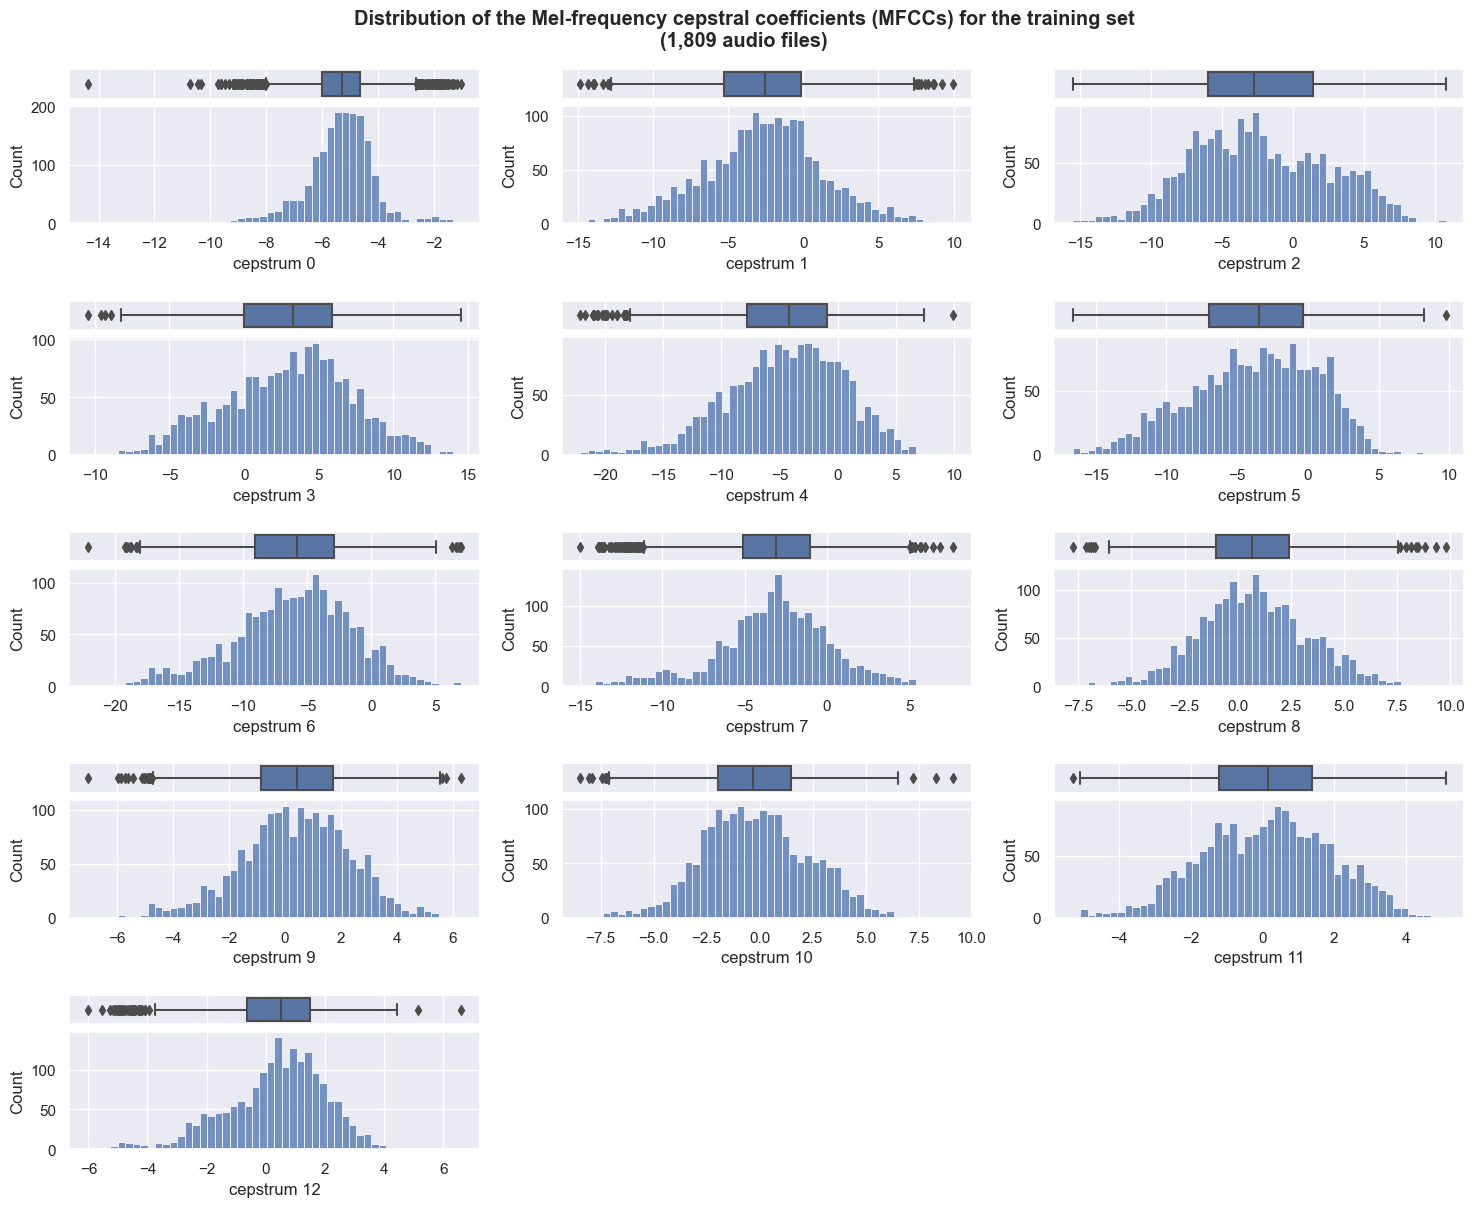

In [11]:
attr_list = ["cepstrum "+str(i) for i in range(0,NUMCEP)]
show_hist_box(X_train, attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set", img_path="img/", do_save_to_disk=False, num_plots=NUMCEP)

#### Boxplots comparing male and female MFCCs distributions
According to [Emmanuel Deruty](https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040), if a cepstral coefficient has a positive value, the majority of the spectral energy is concentrated in the low-frequency regions. On the other hand, if a cepstral coefficient has a negative value, it represents that most of the spectral energy is concentrated at high frequencies. Therefore, since female voices are generally higher pitched than males', we expect to observe female distributions with lower cepstrum distributions than males'.

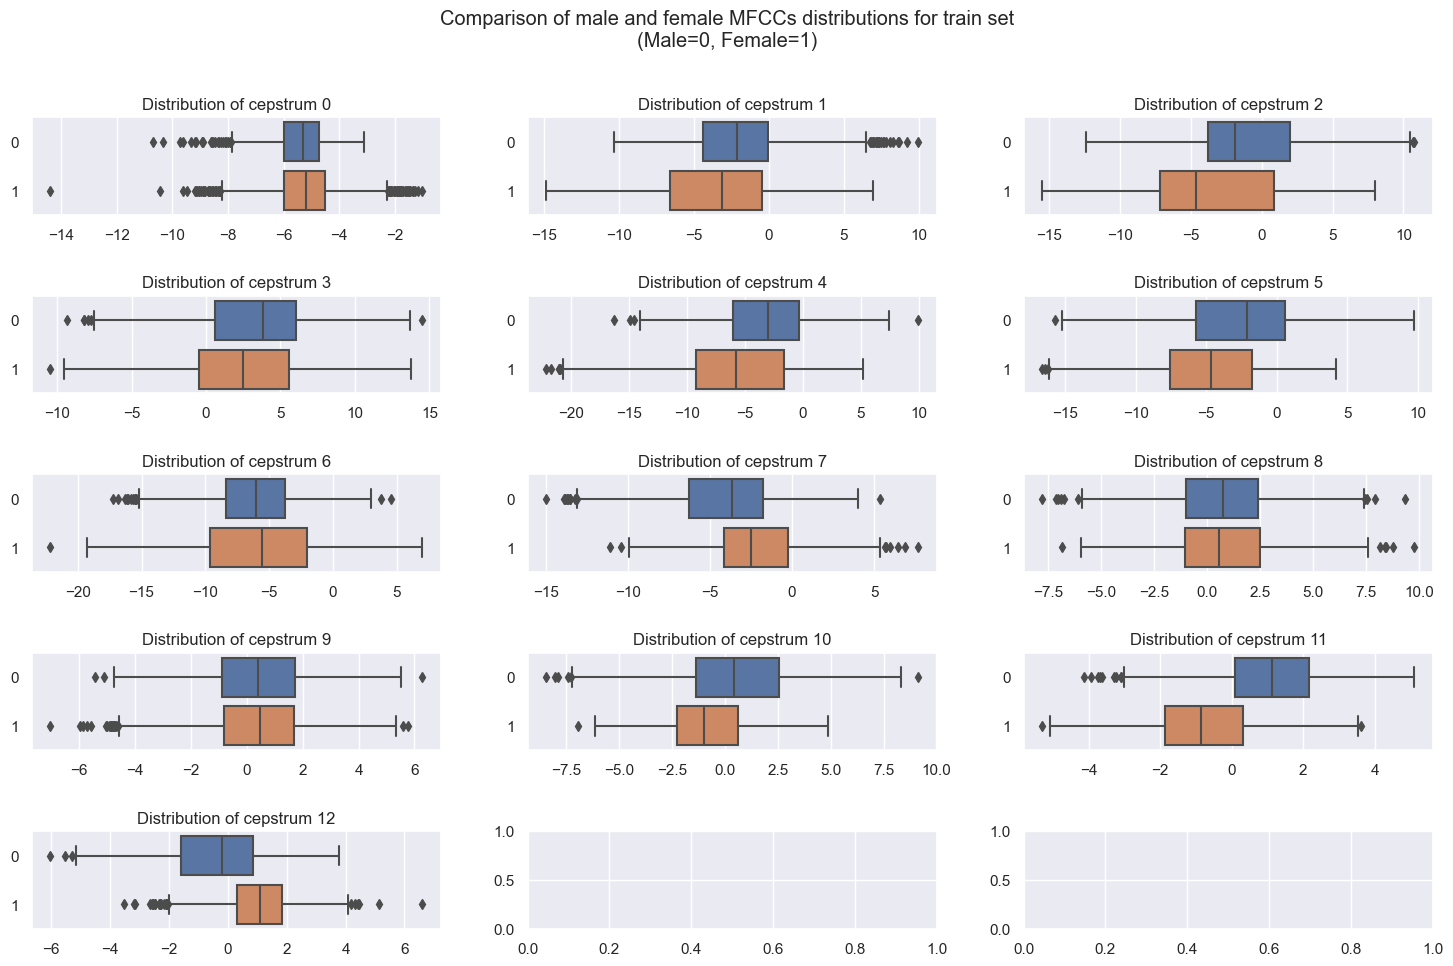

In [12]:
# Compare male and female data (before removing outliers)

male_train_idx = np.where(y_train == 0)
female_train_idx = np.where(y_train == 1)

fig, axs = plt.subplots(nrows=math.ceil(NUMCEP/3), ncols=3, figsize=(15,10), sharex=False, sharey=False)
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    sns.boxplot(data=[X_train[np.ix_(male_train_idx[0], [i])].T, X_train[np.ix_(female_train_idx[0], [i])].T], orient="h", ax=ax)
    ax.set(title=f'Distribution of {col}')
plt.suptitle(f'Comparison of male and female MFCCs distributions for train set\n(Male=0, Female=1)')
plt.tight_layout(pad=2)
plt.show()

In [13]:
cepstrum_fem_lt_male = []
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    male_ceptstrum_dist = X_train[np.ix_(male_train_idx[0], [i])].T 
    female_ceptstrum_dist = X_train[np.ix_(female_train_idx[0], [i])].T
    
    # add to list if female cepstrum mean less than male's cepstrum mean 
    if (female_ceptstrum_dist.mean() < male_ceptstrum_dist.mean()):
        cepstrum_fem_lt_male.append(i)
        
print(f"Female cepstrum mean is lower than Male cepstrum mean in {len(cepstrum_fem_lt_male)/len(attr_list):.2%} of the cases ({len(cepstrum_fem_lt_male)}/{len(attr_list)})")

Female cepstrum mean is lower than Male cepstrum mean in 61.54% of the cases (8/13)


### Detect outliers
We first try to detect Outliers using the Interquartile method, as follows:
- Multiply the interquartile range (IQR) by 1.5.
- Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
- Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.

In [14]:
X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train, 1.5)

• Q1: [-5.99 -5.27 -5.96 ... -1.98 -1.21 -0.63]
• Q3: [-4.64 -0.18  1.39 ...  1.48  1.38  1.5 ]
• IQR:[1.35 5.09 7.35 ... 3.46 2.59 2.13]
• lower_bounds (Q1 - 1.5 * IQR): [ -8.01 -12.9  -16.98 ...  -7.17  -5.09  -3.82]
• upper_bounds (Q3 + 1.5 * IQR): [-2.62  7.46 12.42 ...  6.66  5.26  4.69]

Removed 288 outliers (15.9%)


We relax the method a bit, by multiplying the IQR by 2 instead of 1.5.

In [15]:
X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train, 2)

• Q1: [-5.99 -5.27 -5.96 ... -1.98 -1.21 -0.63]
• Q3: [-4.64 -0.18  1.39 ...  1.48  1.38  1.5 ]
• IQR:[1.35 5.09 7.35 ... 3.46 2.59 2.13]
• lower_bounds (Q1 - 2 * IQR): [ -8.68 -15.45 -20.65 ...  -8.9   -6.38  -4.89]
• upper_bounds (Q3 + 2 * IQR): [-1.95 10.   16.09 ...  8.39  6.55  5.75]

Removed 81 outliers (4.5%)


#### Histograms of Male and Female together (without outliers)

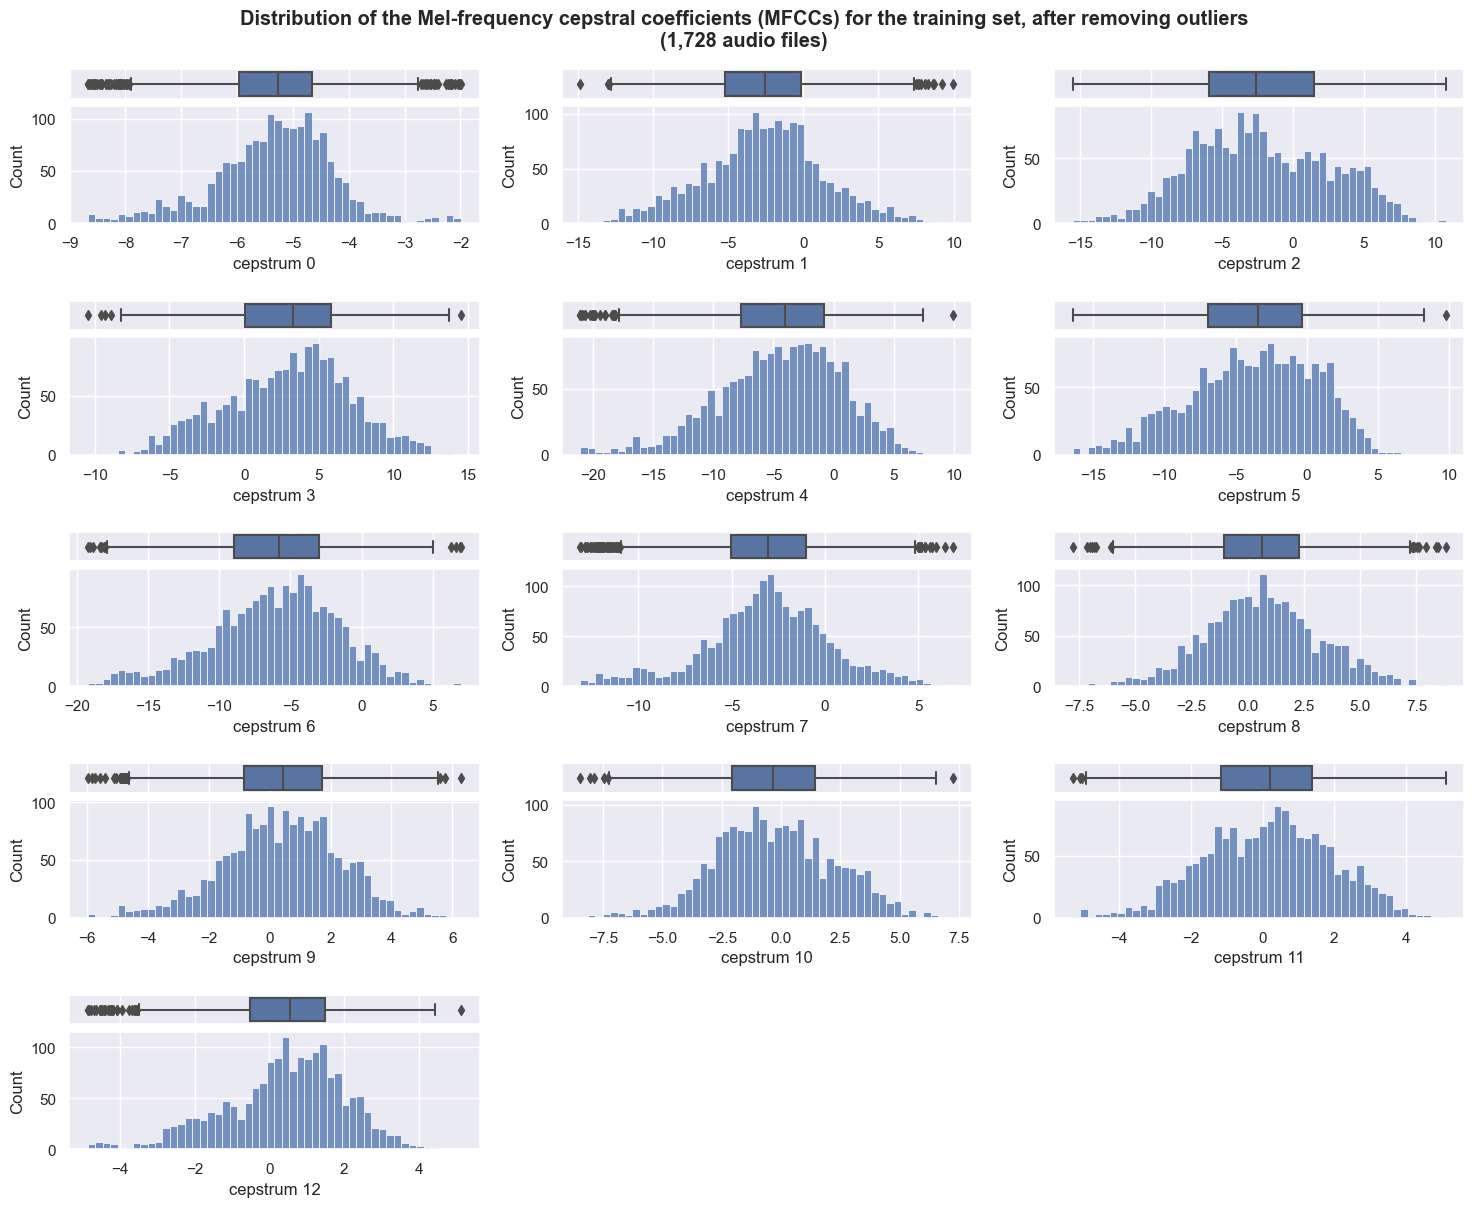

In [16]:
show_hist_box(X_train_no_outliers, attr_list=attr_list, title="Distribution of the Mel-frequency cepstral coefficients (MFCCs) for the training set, after removing outliers", img_path="img/", do_save_to_disk=False, num_plots=NUMCEP)

#### Boxplots comparing male and female MFCCs distributions (without outliers)

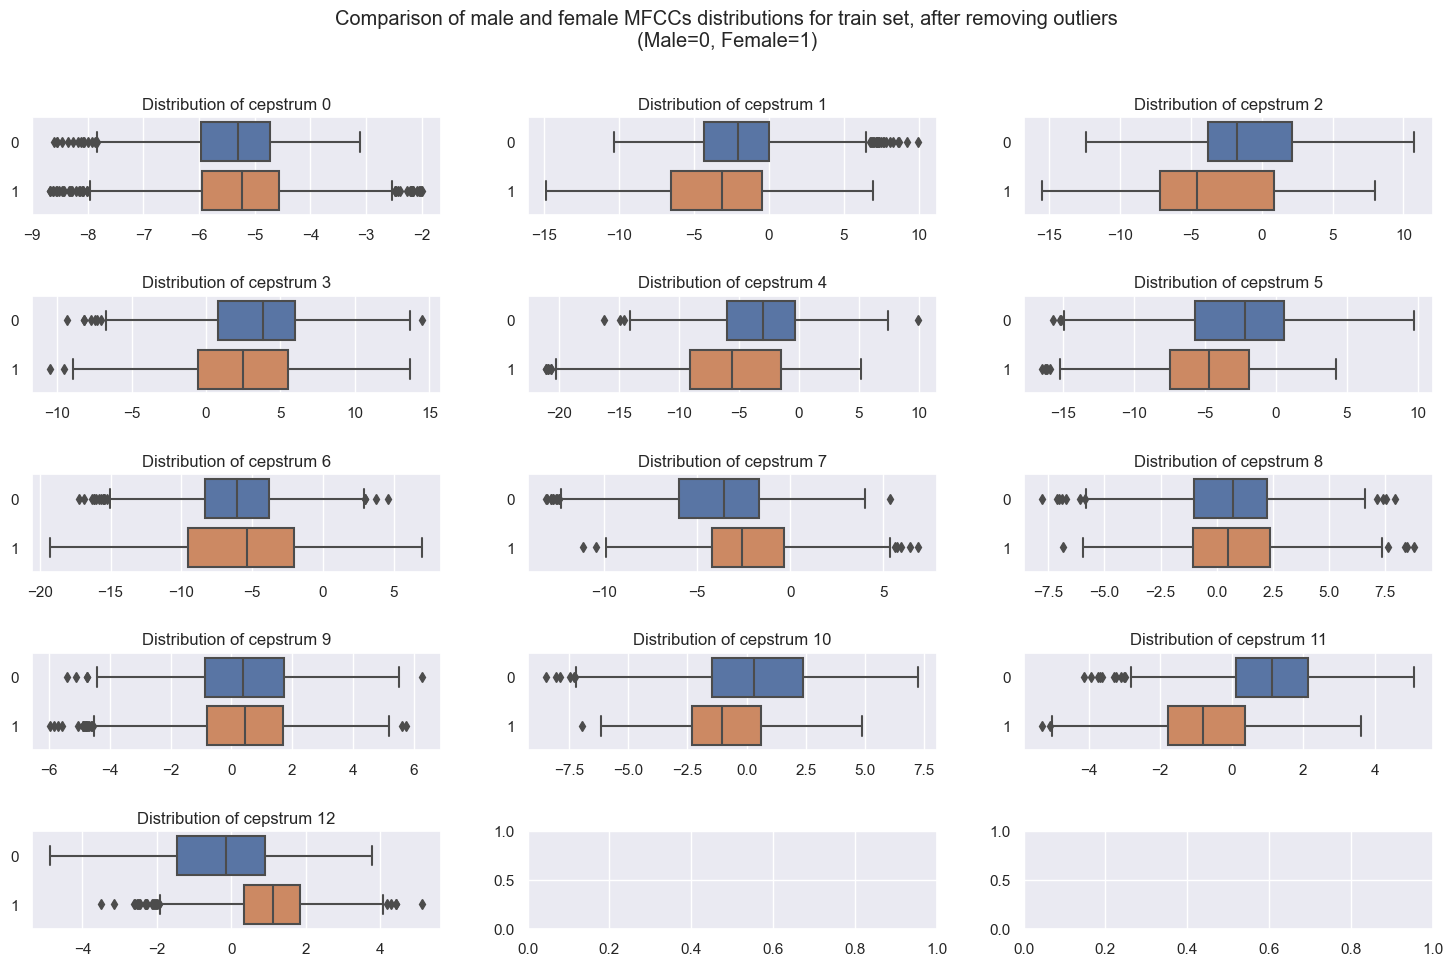

In [17]:
male_train_no_outliers_idx = np.where(y_train_no_outliers == 0)
female_train_no_outliers_idx = np.where(y_train_no_outliers == 1)

fig, axs = plt.subplots(nrows=math.ceil(NUMCEP/3), ncols=3, figsize=(15,10), sharex=False, sharey=False)
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    sns.boxplot(data=[X_train_no_outliers[np.ix_(male_train_no_outliers_idx[0], [i])].T, X_train_no_outliers[np.ix_(female_train_no_outliers_idx[0], [i])].T], orient="h", ax=ax)
    ax.set(title=f'Distribution of {col}')
plt.suptitle(f'Comparison of male and female MFCCs distributions for train set, after removing outliers\n(Male=0, Female=1)')
plt.tight_layout(pad=2)
plt.show()

In [18]:
cepstrum_fem_lt_male = []
for i, (col,ax) in enumerate(zip(attr_list, axs.flatten())):
    male_ceptstrum_dist = X_train_no_outliers[np.ix_(male_train_no_outliers_idx[0], [i])].T 
    female_ceptstrum_dist = X_train_no_outliers[np.ix_(female_train_no_outliers_idx[0], [i])].T
    
    # add to list if female cepstrum mean less than male's cepstrum mean 
    if (female_ceptstrum_dist.mean() < male_ceptstrum_dist.mean()):
        cepstrum_fem_lt_male.append(i)
        
print(f"Female cepstrum mean is lower than Male cepstrum mean in {len(cepstrum_fem_lt_male)/len(attr_list):.2%} of the cases ({len(cepstrum_fem_lt_male)}/{len(attr_list)})")

Female cepstrum mean is lower than Male cepstrum mean in 61.54% of the cases (8/13)


We can see that MFCCs are somewhat correlated to the gender of the speakers.

### Normalize data

Standardization of the dataset is a common requirement for many machine learning estimators implemented in scikit-learn; \
They might behave badly if the individual features do not more or less look like standard normally distributed data: **Gaussian with zero mean and unit variance** ([source](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)).

In [19]:
## if we decide to keep outliers after all
# X_train_no_outliers = X_train
# y_train_no_outliers = y_train

In [20]:
print("Before normalization: ")
with np.printoptions(precision=2, threshold=10):
    print(f"• X_train_no_outliers means: {np.mean(X_train_no_outliers, axis=0)}")
    print(f"• X_train_no_outliers std:   {np.std(X_train_no_outliers, axis=0)}")
    print(f"• X_test means:  {np.mean(X_test, axis=0)}")
    print(f"• X_test std:    {np.std(X_test, axis=0)}")
    
# Center to the mean and component wise scale to unit variance.
X_train_norm = preprocessing.scale(X_train_no_outliers, axis=0)
X_test_norm = preprocessing.scale(X_test, axis=0)

print("\n\nAfter normalization: ")
with np.printoptions(precision=2, threshold=10):
    print(f"• X_train_norm means: {np.mean(X_train_norm, axis=0)}")
    print(f"• X_train_norm std:   {np.std(X_train_norm, axis=0)}")
    print(f"• X_test_norm means:  {np.mean(X_test_norm, axis=0)}")
    print(f"• X_test_norm std:    {np.std(X_test_norm, axis=0)}")

Before normalization: 
• X_train_no_outliers means: [-5.35 -2.65 -2.26 ... -0.26  0.13  0.4 ]
• X_train_no_outliers std:   [1.08 4.01 4.89 ... 2.49 1.77 1.62]
• X_test means:  [-5.77 -1.86 -5.05 ... -0.11  0.64  0.64]
• X_test std:    [1.08 3.33 6.02 ... 2.13 1.59 1.44]


After normalization: 
• X_train_norm means: [ 6.93e-15  1.08e-15 -1.83e-16 ... -2.11e-16 -2.15e-16 -2.94e-17]
• X_train_norm std:   [1. 1. 1. ... 1. 1. 1.]
• X_test_norm means:  [-3.30e-15  3.03e-17 -4.60e-16 ...  6.71e-17 -1.30e-15  5.22e-16]
• X_test_norm std:    [1. 1. 1. ... 1. 1. 1.]


## Train ML models

### Naive Bayes classifier

In [21]:
clf = GaussianNB()
clf.fit(X_train_norm, y_train_no_outliers.ravel())
print(clf)

print("Gaussian Naive Bayes classifier:")

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

GaussianNB()
Gaussian Naive Bayes classifier:
• Mean training accuracy:  85.94%
• Mean testing accuracy:   80.31%


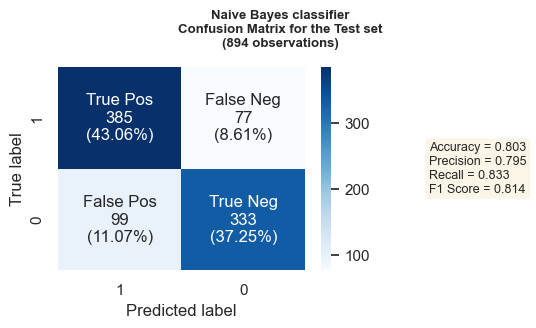

In [22]:
y_pred = clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "Naive Bayes classifier\nConfusion Matrix for the Test set")
NB_metrics = compute_statistics(cf_matrix)

### Logistic Regression

In [23]:
clf = LogisticRegression(random_state=0)
print(clf)

clf.fit(X_train_norm, y_train_no_outliers.ravel())

print("Logistic regression classifier:")

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

LogisticRegression(random_state=0)
Logistic regression classifier:
• Mean training accuracy:  86.11%
• Mean testing accuracy:   86.80%


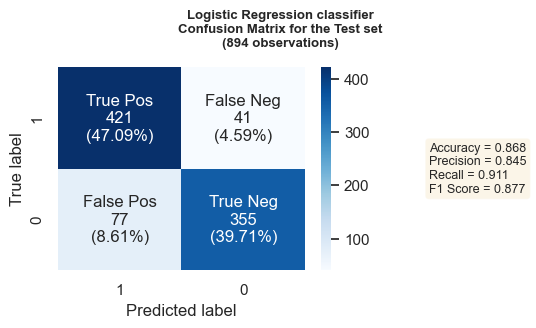

In [24]:
y_pred = clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "Logistic Regression classifier\nConfusion Matrix for the Test set")
LR_metrics = compute_statistics(cf_matrix)

### Support Vector Machines

In [25]:
print("SVM classifier:")
  
# RBF kernel
clf = svm.SVC(kernel='rbf')
print(clf)
clf.fit(X_train_norm, y_train_no_outliers.ravel())

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers)
print(f"• Mean training accuracy (radial basis fucntion (rbf) kernel): {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy  (radial basis fucntion (rbf) kernel): {test_acc:>7.2%}")
print()

# Try training with different degrees of the polynomial kernel function
for degree in range(1,4):
    clf = svm.SVC(kernel='poly', degree=degree)
    print(clf)
    clf.fit(X_train_norm, y_train_no_outliers.ravel())
    
    # compute mean accuracy on the train data and labels.
    train_acc = clf.score(X_train_norm, y_train_no_outliers)
    print(f"• Mean training accuracy (polynomial kernel of degree {degree}): {train_acc:>7.2%}")

    # compute mean accuracy on the test data and labels.
    test_acc = clf.score(X_test_norm, y_test)
    print(f"• Mean testing accuracy  (polynomial kernel of degree {degree}): {test_acc:>7.2%}")
    print()
    
   
# best classifier 
print("Best classifier:")
clf = svm.SVC(kernel='poly', degree=1)
print(clf)
clf.fit(X_train_norm, y_train_no_outliers.ravel())

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_no_outliers)
print(f"• Mean training accuracy (polynomial kernel of degree {degree}): {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy  (polynomial kernel of degree {degree}): {test_acc:>7.2%}")

SVM classifier:
SVC()
• Mean training accuracy (radial basis fucntion (rbf) kernel):  99.02%
• Mean testing accuracy  (radial basis fucntion (rbf) kernel):  80.65%

SVC(degree=1, kernel='poly')
• Mean training accuracy (polynomial kernel of degree 1):  86.86%
• Mean testing accuracy  (polynomial kernel of degree 1):  86.02%

SVC(degree=2, kernel='poly')
• Mean training accuracy (polynomial kernel of degree 2):  93.00%
• Mean testing accuracy  (polynomial kernel of degree 2):  64.32%

SVC(kernel='poly')
• Mean training accuracy (polynomial kernel of degree 3):  97.92%
• Mean testing accuracy  (polynomial kernel of degree 3):  79.75%

Best classifier:
SVC(degree=1, kernel='poly')
• Mean training accuracy (polynomial kernel of degree 3):  86.86%
• Mean testing accuracy  (polynomial kernel of degree 3):  86.02%


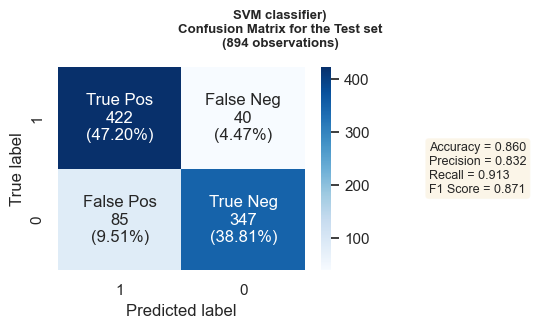

In [26]:
y_pred = clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "SVM classifier)\nConfusion Matrix for the Test set")
SVM_metrics = compute_statistics(cf_matrix)

### Random Forest classifier

In [27]:
# clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
# clf.fit(X_train_norm, y_train_no_outliers.ravel())
# print(clf)

# print("Random Forest classifier:")

# train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
# print(f"• Mean training accuracy: {train_acc:>7.2%}")

# test_acc = clf.score(X_test_norm, y_test)
# print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

In [28]:
start_time = time.time()

# parameters for GridSearch
param_grid = [{'n_estimators': [100,500,1000], 'max_features':['sqrt']}]

### Training and Evaluating Random Forest Regressor
clf = RandomForestClassifier()

#### Fine-Tune the model using Grid Search
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=3)

grid_search.fit(X_train_norm, y_train_no_outliers.ravel())
best_clf = grid_search.best_estimator_
print(best_clf)

elapsed_time = time.time() - start_time
print(f"Elapsed time to train model: {elapsed_time:.3f} seconds")

train_acc = best_clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = best_clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.754) total time=   0.4s
[CV 2/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.691) total time=   0.4s
[CV 3/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.789) total time=   0.4s
[CV 4/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.719) total time=   0.5s
[CV 5/5] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.545) total time=   0.5s
[CV 1/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.740) total time=   2.4s
[CV 2/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.691) total time=   2.0s
[CV 3/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.795) total time=   1.8s
[CV 4/5] END max_features=sqrt, n_estimators=500;, score=(train=1.000, test=0.733) total time=   2.1s
[CV 5/5] END max_featu

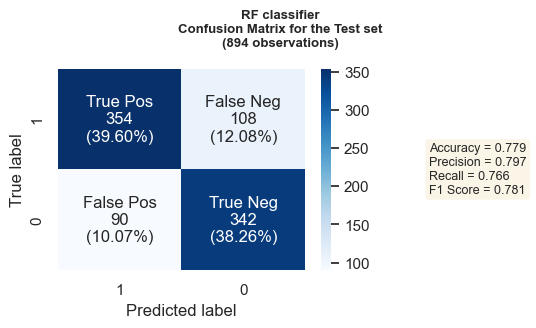

In [29]:
y_pred = best_clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "RF classifier\nConfusion Matrix for the Test set")
RF_metrics = compute_statistics(cf_matrix)

### Neural Network

In [30]:
# Strength of the L2 regularization term alpha default=0.0001
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(100, 100), activation='relu', alpha=0.0001, batch_size='auto', learning_rate_init=0.001, max_iter=100)
print(clf)

clf.fit(X_train_norm, y_train_no_outliers.ravel())

print("Neural Network classifier:")

train_acc = clf.score(X_train_norm, y_train_no_outliers.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = clf.score(X_test_norm, y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=100, random_state=1)
Neural Network classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   81.43%


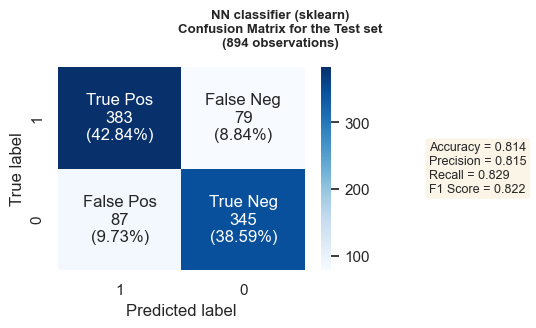

In [31]:
y_pred = clf.predict(X_test_norm)
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "NN classifier (sklearn)\nConfusion Matrix for the Test set")
NNSK_metrics = compute_statistics(cf_matrix)

### Neural Network (PyTorch)

We build a NN with 2 hidden layers of 100 nodes each, ReLU activation functions, and a Sigmoid for the last activation function. We choose a batch size of 128.

In [32]:
BATCH_SIZE = 128

In [33]:
# Custom Dataset
class BinaryDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array
    
    def __len__(self):
        return len(self.input_array)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

In [34]:
class NNClassifier(torch.nn.Module):
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.input_layer = torch.nn.Linear(NUMCEP, 100)
        self.activation1 = torch.nn.ReLU()
        self.hidden_layer1 = torch.nn.Linear(100, 100)
        self.activation2 = torch.nn.ReLU()
        self.hidden_layer2 = torch.nn.Linear(100, 100)
        self.activation3 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(100, 1)
        self.activation_out = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation1(x)
        x = self.hidden_layer1(x)
        x = self.activation2(x)
        x = self.hidden_layer2(x)
        x = self.activation3(x)
        x = self.output_layer(x)
        x = self.activation_out(x)
        return x

In [35]:
train_dataset = BinaryDataset(X_train_norm, y_train_no_outliers)
test_dataset = BinaryDataset(X_test_norm, y_test)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=128,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=128,
                             shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [36]:
model = NNClassifier().to(device)
print(model)

loss_fn = torch.nn.BCELoss() # Binary cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)

# adjust the learning rate based on the number of epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9) # Decays the learning rate of each parameter group by gamma every step_size epochs

NNClassifier(
  (input_layer): Linear(in_features=13, out_features=100, bias=True)
  (activation1): ReLU()
  (hidden_layer1): Linear(in_features=100, out_features=100, bias=True)
  (activation2): ReLU()
  (hidden_layer2): Linear(in_features=100, out_features=100, bias=True)
  (activation3): ReLU()
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation_out): Sigmoid()
)


In [37]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    epoch_loss_history = []
    epoch_accuracy_history = []
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # number of correct predictions for this batch
        correct_batch = (((y_pred > 0.5) * 1.0) == y_batch).sum().item()
        
        # loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = correct_batch / len(X_batch)
        
        # record loss and accuracy for each batch
        epoch_loss_history.append(batch_loss)
        epoch_accuracy_history.append(batch_accuracy)

        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:02d} "
                f"batch_loss={batch_loss:.3f} "
                f"batch_acc={batch_accuracy:.3f} "
            )
    
    return epoch_loss_history, epoch_accuracy_history

In [38]:
def test_epoch(dataloader, model, loss_fn):
    model.eval()
    correct_epoch = 0
    test_loss = 0
    with torch.no_grad():

        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss = loss.item()

            correct_epoch += (((y_pred > 0.5) * 1.0) == y_batch).sum().item()

    epoch_avg_test_loss = test_loss/len(dataloader)
    epoch_avg_test_acc = correct_epoch/len(dataloader.dataset)

    print(
        f"Test set:  Average loss: {epoch_avg_test_loss:.3f}, Accuracy: {correct_epoch}/{len(dataloader.dataset)} ({epoch_avg_test_acc:.1%})"
    )
    return epoch_avg_test_loss, epoch_avg_test_acc

In [39]:
NUM_EPOCHS = 30
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
    
for t in range(1, NUM_EPOCHS + 1):
    print(f"\n----------- Epoch Nr. {t} -----------")
    train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer, t)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    
    test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    lr_scheduler.step()


----------- Epoch Nr. 1 -----------
Train Epoch: 1-00 batch_loss=0.693 batch_acc=0.539 
Train Epoch: 1-10 batch_loss=0.668 batch_acc=0.617 
Test set:  Average loss: 0.103, Accuracy: 636/894 (71.1%)

----------- Epoch Nr. 2 -----------
Train Epoch: 2-00 batch_loss=0.656 batch_acc=0.664 
Train Epoch: 2-10 batch_loss=0.573 batch_acc=0.883 
Test set:  Average loss: 0.095, Accuracy: 749/894 (83.8%)

----------- Epoch Nr. 3 -----------
Train Epoch: 3-00 batch_loss=0.547 batch_acc=0.867 
Train Epoch: 3-10 batch_loss=0.474 batch_acc=0.852 
Test set:  Average loss: 0.083, Accuracy: 758/894 (84.8%)

----------- Epoch Nr. 4 -----------
Train Epoch: 4-00 batch_loss=0.410 batch_acc=0.883 
Train Epoch: 4-10 batch_loss=0.364 batch_acc=0.875 
Test set:  Average loss: 0.074, Accuracy: 761/894 (85.1%)

----------- Epoch Nr. 5 -----------
Train Epoch: 5-00 batch_loss=0.329 batch_acc=0.898 
Train Epoch: 5-10 batch_loss=0.292 batch_acc=0.852 
Test set:  Average loss: 0.070, Accuracy: 767/894 (85.8%)

----

#### Plot train and test curves

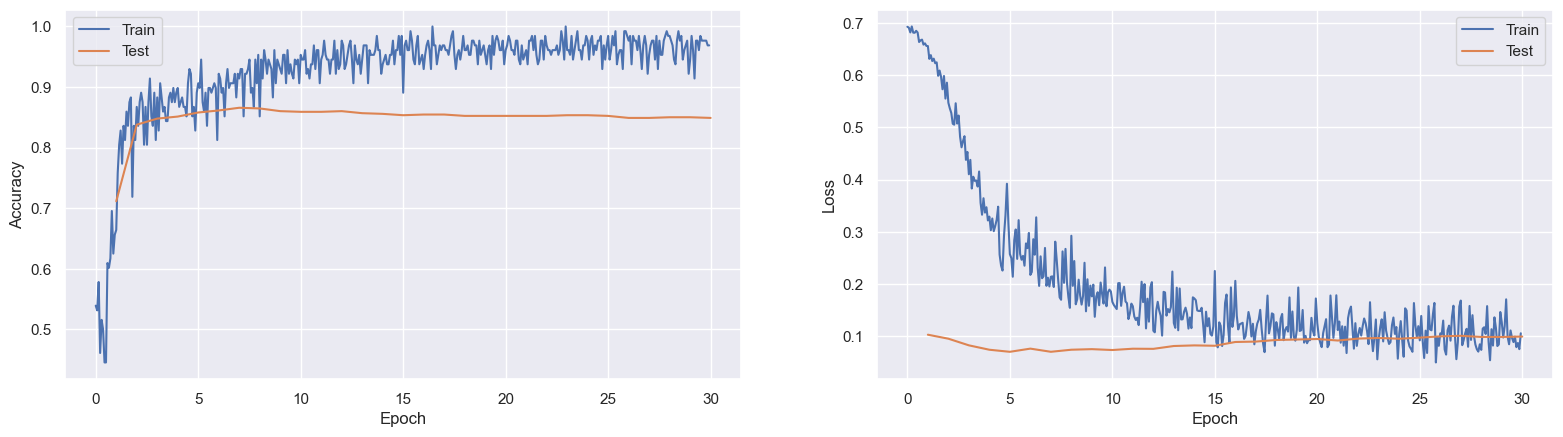

In [40]:
n_train = len(train_acc_history)
t_train = NUM_EPOCHS * np.arange(n_train) / n_train
t_test = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(6.4 * 3, 4.8))
plt.subplot(1, 2, 1)
plt.plot(t_train, train_acc_history, label="Train")
plt.plot(t_test, test_acc_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_test, test_loss_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

**Observation:** The Neural Network model converges after about 25 Epochs.

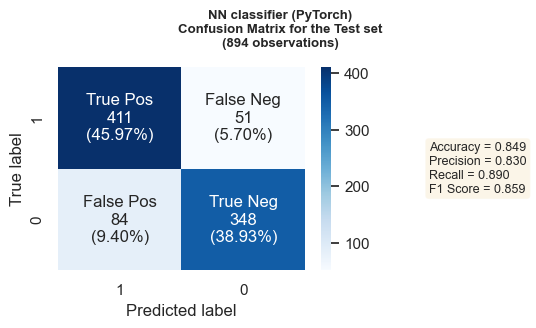

In [41]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test_norm, dtype=torch.float))
    y_pred = (y_pred > 0.5) * 1.0
    
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "NN classifier (PyTorch)\nConfusion Matrix for the Test set")
NNPT_metrics = compute_statistics(cf_matrix)

### CNN

In [42]:
BATCH_SIZE = 128

In [43]:
class BinaryDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array
    
    def __len__(self):
        return len(self.input_array)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

In [44]:
class CNNClassifier(torch.nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.activation1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5)
        self.activation2 = torch.nn.ReLU()
        self.conv3 = torch.nn.Conv1d(in_channels=32, out_channels=1, kernel_size=5)
        self.activation3 = torch.nn.ReLU()
        self.pool = torch.nn.AdaptiveAvgPool1d(1)
        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.pool(x)
        x = self.flatten(x)
        return x

In [45]:
train_dataset = BinaryDataset(X_train_norm, y_train_no_outliers)
test_dataset = BinaryDataset(X_test_norm, y_test)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=128,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=128,
                             shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [46]:
model = CNNClassifier().to(device)
print(model)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

CNNClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (activation1): ReLU()
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (activation2): ReLU()
  (conv3): Conv1d(32, 1, kernel_size=(5,), stride=(1,))
  (activation3): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [47]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    epoch_loss_history = []
    epoch_accuracy_history = []
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        X_batch = torch.unsqueeze(X_batch, dim=1)
        y_pred = model(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # number of correct predictions for this batch
        correct_batch = (((y_pred > 0.5) * 1.0) == y_batch).sum().item()
        
        # loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = correct_batch / len(X_batch)
        
        # record loss and accuracy for each batch
        epoch_loss_history.append(batch_loss)
        epoch_accuracy_history.append(batch_accuracy)
        
        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:02d} "
                f"batch_loss={batch_loss:.3f} "
                f"batch_acc={batch_accuracy:.3f} "
            )
    
    return epoch_loss_history, epoch_accuracy_history

In [48]:
def test_epoch(dataloader, model, loss_fn):
    model.eval()
    correct_epoch = 0
    test_loss = 0
    with torch.no_grad():

        for X_batch, y_batch in dataloader:
            
            X_batch = torch.unsqueeze(X_batch, dim=1)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss = loss.item()

            correct_epoch += (((y_pred > 0.5) * 1.0) == y_batch).sum().item()

    epoch_avg_test_loss = test_loss/len(dataloader)
    epoch_avg_test_acc = correct_epoch/len(dataloader.dataset)

    print(
        f"Test set:  Average loss: {epoch_avg_test_loss:.3f}, Accuracy: {correct_epoch}/{len(dataloader.dataset)} ({epoch_avg_test_acc:.1%})"
    )
    return epoch_avg_test_loss, epoch_avg_test_acc

In [49]:
NUM_EPOCHS = 30
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
    
for t in range(1, NUM_EPOCHS + 1):
    print(f"\n----------- Epoch Nr. {t} -----------")
    train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer, t)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    
    test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    lr_scheduler.step()


----------- Epoch Nr. 1 -----------
Train Epoch: 1-00 batch_loss=0.697 batch_acc=0.523 
Train Epoch: 1-10 batch_loss=0.635 batch_acc=0.586 
Test set:  Average loss: 0.076, Accuracy: 622/894 (69.6%)

----------- Epoch Nr. 2 -----------
Train Epoch: 2-00 batch_loss=0.625 batch_acc=0.680 
Train Epoch: 2-10 batch_loss=0.598 batch_acc=0.805 
Test set:  Average loss: 0.072, Accuracy: 691/894 (77.3%)

----------- Epoch Nr. 3 -----------
Train Epoch: 3-00 batch_loss=0.606 batch_acc=0.781 
Train Epoch: 3-10 batch_loss=0.591 batch_acc=0.812 
Test set:  Average loss: 0.058, Accuracy: 721/894 (80.6%)

----------- Epoch Nr. 4 -----------
Train Epoch: 4-00 batch_loss=0.566 batch_acc=0.828 
Train Epoch: 4-10 batch_loss=0.530 batch_acc=0.828 
Test set:  Average loss: 0.056, Accuracy: 724/894 (81.0%)

----------- Epoch Nr. 5 -----------
Train Epoch: 5-00 batch_loss=0.498 batch_acc=0.875 
Train Epoch: 5-10 batch_loss=0.504 batch_acc=0.906 
Test set:  Average loss: 0.053, Accuracy: 728/894 (81.4%)

----

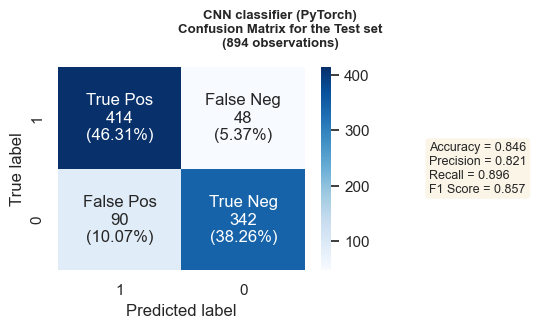

In [50]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.unsqueeze(torch.tensor(X_test_norm, dtype=torch.float), dim=1))
    y_pred = (y_pred > 0.5) * 1.0
    
cf_matrix = confusion_matrix(y_test, y_pred)
fig = show_confusion_matrix(cf_matrix, "CNN classifier (PyTorch)\nConfusion Matrix for the Test set")
CNN_metrics = compute_statistics(cf_matrix)

## Compare ML models

In [51]:
metrics_data = np.array([NB_metrics, LR_metrics, SVM_metrics, RF_metrics, NNSK_metrics, NNPT_metrics, CNN_metrics])

df = pd.DataFrame(metrics_data, columns=["Accuracy", "Precision", "Recall", "F1-Score"])
df.index = ['NB', 'LR', 'SVM', 'RF', 'NN (SK)', 'NN (PT)', 'CNN']

with pd.option_context('display.precision', 3):
    display(df)

Accuracy  Precision  Recall  F1-Score
NB          0.803      0.795   0.833     0.814
LR          0.868      0.845   0.911     0.877
SVM         0.860      0.832   0.913     0.871
RF          0.779      0.797   0.766     0.781
NN (SK)     0.814      0.815   0.829     0.822
NN (PT)     0.849      0.830   0.890     0.859
CNN         0.846      0.821   0.896     0.857

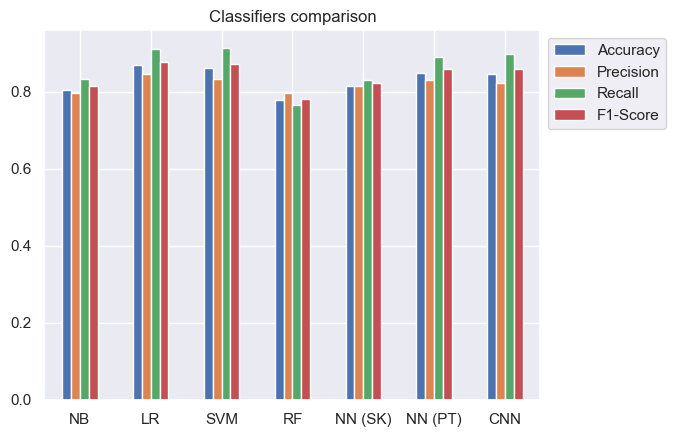

In [52]:
ax = df.plot.bar(rot=0)
ax.set_title("Classifiers comparison")
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

**Conclusion:** All classifiers perform quite well (all metrics are over 80%). The best one is the SVM. CNN could probably be increased by tuning the model, as it should be specifically well suited for audio.

### Visualisation

Let's try to find patterns by visualizing our dataset using PCA dimensionality reduction.

#### Reduce dimensionality to 2 dimensions using PCA

In [53]:
reduced_X_train = PCA(n_components=2).fit_transform(X_train_norm)
reduced_X_test = PCA(n_components=2).fit_transform(X_test_norm)

print(f"• Reduced train set: {reduced_X_train.shape[0]:,} samples, {reduced_X_train.shape[1]} dimensions")
print(f"• Reduced test set:  {reduced_X_test.shape[0]:,} samples, {reduced_X_test.shape[1]} dimensions")

• Reduced train set: 1,728 samples, 2 dimensions
• Reduced test set:  894 samples, 2 dimensions


In [54]:
# run K-means algorithm on reduced train set with 2 clusters (for male and female)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=2)
kmeans.fit(reduced_X_train)
kmeans.labels_

array([1, 1, 0, ..., 0, 0, 0], dtype=int32)

In [55]:
train_acc = (kmeans.predict(reduced_X_train) == y_train_no_outliers.ravel()).sum() / len(y_train_no_outliers)
print(f"• Mean testing accuracy:  {train_acc:>7.2%}")

test_acc = (kmeans.predict(reduced_X_test) == y_test.ravel()).sum() / len(y_test)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

• Mean testing accuracy:   27.84%
• Mean testing accuracy:   57.27%


#### Visualize the results on PCA-reduced data

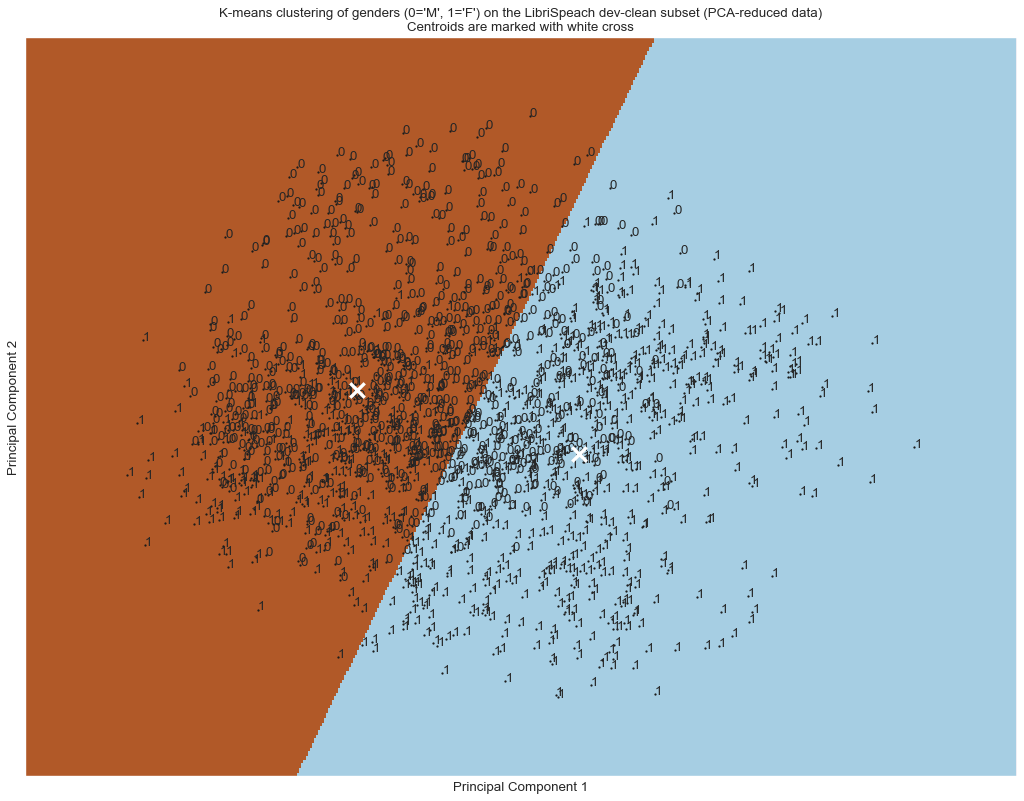

In [56]:
figure(figsize=(16, 12), dpi=80)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_X_train[:, 0].min() - 1, reduced_X_train[:, 0].max() + 1
y_min, y_max = reduced_X_train[:, 1].min() - 1, reduced_X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Paired, aspect="auto", origin="lower")
plt.plot(reduced_X_train[:, 0], reduced_X_train[:, 1], "k.", markersize=2)

# annotate each point with its corresponding gender label
for i, l in enumerate(y_train_no_outliers.ravel()):
    plt.annotate(int(l), (reduced_X_train[i, 0], reduced_X_train[i, 1]))
    
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_

plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3, color="w", zorder=10)

plt.title(
    f"K-means clustering of genders (0='M', 1='F') on the LibriSpeach dev-clean subset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.xticks(())
plt.yticks(())
plt.show()

**Obervation:** We can see a pretty clear separation betwen both genders.

# Part 2. Speaker Classification from audio files

In this part, we try to predict who is the speaker of an unseen audio file, by training a multi-class classifier on previous audio files of these speakers. This time, we will use the [wav2vec 2.0](https://github.com/facebookresearch/fairseq/blob/main/examples/wav2vec/README.md) base model (No Finetuning), and use it to extract features from audio signals. We will use the same audio files as we used in the previous task, however this time, we will apply the model on 2 seconds subsequent chunks instead of extracting the features from the whole audio file at once.

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [58]:
# # wav2vec 2.0 - the following code has been modified to work with fairseq Version: 0.10.2, see https://github.com/facebookresearch/fairseq/issues/3134
# wav2vec2_checkpoint_path = './models/wav2vec_small.pt'
# checkpoint = torch.load(wav2vec2_checkpoint_path)
# wav2vec2_encoder = fairseq.models.wav2vec.Wav2Vec2Model.build_model(checkpoint['args'])
# wav2vec2_encoder.load_state_dict(checkpoint['model'])

In [59]:
# wav2vec 2.0  - the following code has been modified to work with fairseq Version: 0.12.2, see https://github.com/facebookresearch/fairseq/issues/3134
wav2vec2_checkpoint_path = './models/wav2vec_small.pt'
checkpoint = torch.load(wav2vec2_checkpoint_path)
cfg = fairseq.dataclass.utils.convert_namespace_to_omegaconf(checkpoint['args'])
wav2vec2_encoder = fairseq.models.wav2vec.Wav2Vec2Model.build_model(cfg.model).to(device)

### Extract wav2vec features from audio files

In [60]:
NUM_FEATURES = 768

In [61]:
def extract_wav2vec_features(speaker_id, device):
    speaker_features = np.zeros((0, NUM_FEATURES))  # create new array for features for this speaker
    speaker_audio_file_count = 0 
    
    speaker_path = DEV_CLEAN + str(speaker_id)
    
    for path in tqdm(glob.glob(f'{speaker_path}/*/*.flac', recursive=True), desc=f"Speaker {speaker_id:>4}"):        
        file_features = torch.zeros(1, 0, NUM_FEATURES).to(device)
        with open(path, 'rb') as f:
            data, samplerate = sf.read(f)  
            
            # read chunks of 2 seconds (2 x 16,000 frames/sec)
            blocks = sf.blocks(path, blocksize=32_000)  
            for block in blocks:
                if block.shape[0] < 400:
                  # prevent "Kernel size can't be greater than actual input size" error
                  print(f"    error: block of {block.shape[0]} frames too small - discard it")
                  continue
                block_tensor = torch.from_numpy(block).to(torch.float32)
                block_tensor = torch.unsqueeze(block_tensor, dim=0).to(device)
                # print(block_tensor.shape)
                block_features = wav2vec2_encoder(block_tensor, features_only=True, mask=False)['x']
                
                # concatenate features for current file
                file_features = torch.cat((file_features, block_features.to(device)), dim=1)

        file_features_mean = torch.mean(file_features, dim=1).detach().cpu().numpy()
        speaker_features = np.vstack((speaker_features, file_features_mean))
        
        speaker_audio_file_count += 1
    print(f"Speaker {speaker_id:>4}:", end=" ")
    print(f"{speaker_audio_file_count:>3} audio files", end=", ")

    return speaker_features

In [62]:
def build_dataset_wav2vec(speaker_ids, speakers_gender, device):
    
    dataset = np.zeros((0,NUM_FEATURES+2))  # dataset is comprised of 13 features (MFCCs) + speaker id + label

    for i, speaker_id in enumerate(tqdm(speaker_ids, desc='Extracting features')):
        
        speaker_features = extract_wav2vec_features(speaker_id, device)
        
        if SPEAKER_MEAN_MFCCs == True:
            # take the mean of the mfcc's for each speaker
            speaker_features = np.expand_dims(np.mean(speaker_features, axis=0), axis=1).T   
        

        # Adding speaker id column to 2D NumPy Array
        speaker_id_col = np.empty(speaker_features.shape[0])
        speaker_id_col.fill(speaker_id)
        speaker_features_meta_1 = np.column_stack((speaker_features, speaker_id_col))

        # gender column to be added for this user
        gender = speakers_gender[int(speaker_id)]
        print(f"gender {gender} {'(M)' if gender==0 else '(F)'}")

        # Adding gender column to 2D NumPy Array
        gender_col = np.empty(speaker_features.shape[0])
        gender_col.fill(gender)
        speaker_features_meta_2 = np.column_stack((speaker_features_meta_1, gender_col))

        # add this user to all users
        dataset = np.vstack((dataset, speaker_features_meta_2))

    return dataset

In [63]:
# Extracting the features with wav2vec takes quite a lot of time when run on cpu, so I ran it in on a GPU in Google collab, and saved the resulting files to disk (see next cell)

# start_time = time.time()

# print("Build wav2vec train dataset: ")
# wav2vec_train_dataset = build_dataset_wav2vec(male_ids_train + female_ids_train, speakers_gender, device)
# print(wav2vec_train_dataset.shape, "\n")

# print("Build wav2vec test dataset: ")
# wav2vec_test_dataset = build_dataset_wav2vec(male_ids_test + female_ids_test, speakers_gender, device)
# print(wav2vec_test_dataset.shape, "\n")

# elapsed_time = time.time() - start_time
# print(f"Elapsed time to build the dataset: {elapsed_time:.3f} seconds")

# # save dataset to disk
# np.savetxt('/content/drive/MyDrive/Voiseed/data/wav2vec_train_dataset.csv', wav2vec_train_dataset, delimiter=',')
# np.savetxt('/content/drive/MyDrive/Voiseed/data/wav2vec_test_dataset.csv', wav2vec_test_dataset, delimiter=',')

# # verify files have been successfully saved
# !ls -lh /content/drive/MyDrive/Voiseed/data/

### Merge train and test

The split from the previous cell was not ideal. Since it took too long to re-extract the features, I kept them, but merged the previously split files and re-did the splits in an improved manner.

In [64]:
# load datasets from disk
wav2vec_old_train_dataset = np.loadtxt('./data/wav2vec_train_dataset.csv', delimiter=',')
wav2vec_old_test_dataset = np.loadtxt('./data/wav2vec_test_dataset.csv', delimiter=',')
wav2vec_dataset = np.vstack((wav2vec_old_train_dataset, wav2vec_old_test_dataset))

In [65]:
# merge train and test
print("old train shape: ", wav2vec_old_train_dataset.shape)
print("old test shape:  ", wav2vec_old_test_dataset.shape)
print("merge shape:     ", wav2vec_dataset.shape)

old train shape:  (1242, 770)
old test shape:   (1461, 770)
merge shape:      (2703, 770)


### Train / Test split

In this split, we ensure that each speaker is present in both the Train and Test sets, however, we **ensure that each audio file is in one of the sets only (no leakage)**.

In [66]:
def train_test_split(speaker, train_ratio):
    
    # get all indexes of the specified speaker in dataset
    speaker_indexes = np.where(wav2vec_dataset[:, -2] == speaker_id)[0]
    
    # get the total nb of files of this speaker
    nb_speaker_files = len(speaker_indexes)
    
    # compute the nb of this speaker's files that will go in the test set
    nb_speaker_train_files = math.ceil(nb_speaker_files * train_ratio)
    
    # split the train and test indexes accordingly
    train_idx = speaker_indexes[:nb_speaker_train_files]
    test_idx = speaker_indexes[nb_speaker_train_files:]

    return wav2vec_dataset[train_idx], wav2vec_dataset[test_idx]

In [67]:
TRAIN_RATIO = 0.7

# get all speakers ids in the dataset
speakers = [int(speaker) for speaker in set(wav2vec_dataset[:, -2])]

# create 2 empty datasets for train and test sets
wav2vec_train_dataset = np.zeros((0, NUM_FEATURES + 2))
wav2vec_test_dataset = np.zeros((0, NUM_FEATURES + 2))

# perform the split for each speaker, and add extracted features and corresponding labels to respective datasets
for speaker_id in speakers:
    speaker_train_set, speaker_test_set = train_test_split(speaker_id, TRAIN_RATIO)
    wav2vec_train_dataset = np.vstack((wav2vec_train_dataset, speaker_train_set))
    wav2vec_test_dataset = np.vstack((wav2vec_test_dataset, speaker_test_set))

print(wav2vec_train_dataset.shape)
print(wav2vec_test_dataset.shape)

(1909, 770)
(794, 770)


In [68]:
print("Dataset basic statistics:")
print(f"• Training set: nb audio files: {wav2vec_train_dataset.shape[0]:>5,}; nb features: {wav2vec_train_dataset.shape[1]-2}; nb speakers: {len(set(wav2vec_train_dataset[:, -2]))}, M/F ratio: {(wav2vec_train_dataset[:, -1] == 0).sum()} / {(wav2vec_train_dataset[:, -1] == 1).sum()}")
print(f"• Testing  set: nb audio files: {wav2vec_test_dataset.shape[0]:>5,}; nb features: {wav2vec_test_dataset.shape[1]-2}; nb speakers: {len(set(wav2vec_test_dataset[:, -2]))}, M/F ratio: {(wav2vec_test_dataset[:, -1] == 0).sum()} / {(wav2vec_test_dataset[:, -1] == 1).sum()}")

Dataset basic statistics:
• Training set: nb audio files: 1,909; nb features: 768; nb speakers: 40, M/F ratio: 940 / 969
• Testing  set: nb audio files:   794; nb features: 768; nb speakers: 40, M/F ratio: 389 / 405


### Separate features and label

In [69]:
X_train = wav2vec_train_dataset[:, :NUM_FEATURES]
y_train_gender = wav2vec_train_dataset[:, [-1]]
y_train_speaker = wav2vec_train_dataset[:, [-2]]

X_test = wav2vec_test_dataset[:, :NUM_FEATURES]
y_test_gender = wav2vec_test_dataset[:, [-1]]
y_test_speaker = wav2vec_test_dataset[:, [-2]]

X_train.shape, y_train_gender.shape, y_train_speaker.shape, X_test.shape, y_test_gender.shape, y_test_speaker.shape, 

((1909, 768), (1909, 1), (1909, 1), (794, 768), (794, 1), (794, 1))

## EDA

In [70]:
male_train_idx = np.where(y_train_gender == 0)
female_train_idx = np.where(y_train_gender == 1)

male_test_idx = np.where(y_test_gender == 0)
female_test_idx = np.where(y_test_gender == 1)

total_files = len(X_train)+len(X_test)

print(f"Total audio files in dataset:   {total_files:>6,}")
print()
print(f"Audio files in train dataset:   {len(X_train):>6,} ({len(X_train)/total_files:.2%})")
print(f"• Male files:                   {len(male_train_idx[0]):>6,}")
print(f"• Female files:                 {len(female_train_idx[0]):>6,}")
print()
print(f"Audio files in test dataset:    {len(X_test):>6,} ({len(X_test)/total_files:.2%})")
print(f"• Male files:                   {len(male_test_idx[0]):>6,}")
print(f"• Female files:                 {len(female_test_idx[0]):>6,}")

Total audio files in dataset:    2,703

Audio files in train dataset:    1,909 (70.63%)
• Male files:                      940
• Female files:                    969

Audio files in test dataset:       794 (29.37%)
• Male files:                      389
• Female files:                    405


### Normalize data

In [71]:
print("Before normalization: ")
with np.printoptions(precision=2, threshold=10):
    print(f"• X_train means: {np.mean(X_train, axis=0)}")
    print(f"• X_train std:   {np.std(X_train, axis=0)}")
    print(f"• X_test means:  {np.mean(X_test, axis=0)}")
    print(f"• X_test std:    {np.std(X_test, axis=0)}")
    
# Center to the mean and component wise scale to unit variance.
X_train_norm = preprocessing.scale(X_train, axis=0)
X_test_norm = preprocessing.scale(X_test, axis=0)

print("\nAfter normalization: ")
with np.printoptions(precision=2, threshold=10):
    print(f"• X_train_norm means: {np.mean(X_train_norm, axis=0)}")
    print(f"• X_train_norm std:   {np.std(X_train_norm, axis=0)}")
    print(f"• X_test_norm means:  {np.mean(X_test_norm, axis=0)}")
    print(f"• X_test_norm std:    {np.std(X_test_norm, axis=0)}")

Before normalization: 
• X_train means: [ 0.08  0.3  -0.75 ... -0.3  -0.1  -0.37]
• X_train std:   [0.15 0.13 0.19 ... 0.16 0.15 0.17]
• X_test means:  [ 0.08  0.31 -0.74 ... -0.3  -0.1  -0.38]
• X_test std:    [0.15 0.14 0.19 ... 0.16 0.15 0.17]

After normalization: 
• X_train_norm means: [ 1.41e-16  2.11e-16  2.21e-16 ...  5.50e-17  5.22e-17 -1.31e-16]
• X_train_norm std:   [1. 1. 1. ... 1. 1. 1.]
• X_test_norm means:  [ 4.19e-18 -4.69e-17  2.37e-16 ... -6.60e-17  3.38e-17 -1.01e-16]
• X_test_norm std:    [1. 1. 1. ... 1. 1. 1.]


## A. Quantitative analysis, using prediction models

### Multinomial Logistic Regression

In [72]:
clf = LogisticRegression(random_state=0, multi_class='multinomial', max_iter=1000)
print(clf)

clf.fit(X_train_norm, y_train_speaker.ravel())

print("Logistic regression classifier:")

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_speaker.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)
Logistic regression classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   74.06%


In [73]:
y_pred = clf.predict(X_test_norm)

cf_matrix = confusion_matrix(y_test_speaker, y_pred)
print('Confusion Matrix\n')
print(cf_matrix)

accuracy = accuracy_score(y_test_speaker, y_pred)

weighted_precision = precision_score(y_test_speaker, y_pred, average='weighted')
weighted_recall = recall_score(y_test_speaker, y_pred, average='weighted')
weighted_f1_score = f1_score(y_test_speaker, y_pred, average='weighted')

print('\nAccuracy: {:.2f}\n'.format(accuracy))

# Calculate metrics for each label, and find their average weighted by support 
print('Weighted Precision: {:.2f}'.format(weighted_precision))
print('Weighted Recall: {:.2f}'.format(weighted_recall))
print('Weighted F1-score: {:.2f}'.format(weighted_f1_score))

print('\nClassification Report\n')
print(classification_report(y_test_speaker, y_pred))

LR_multi_metrics = [accuracy, weighted_precision, weighted_recall, weighted_f1_score]

Confusion Matrix

[[ 9  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  2 16 ...  0  0  0]
 ...
 [ 0  0  1 ... 18  0  1]
 [ 0  0  0 ...  0 21  0]
 [ 0  1  0 ...  6  0  2]]

Accuracy: 0.74

Weighted Precision: 0.76
Weighted Recall: 0.74
Weighted F1-score: 0.73

Classification Report

              precision    recall  f1-score   support

        84.0       1.00      0.47      0.64        19
       174.0       0.57      0.71      0.63        17
       251.0       0.76      0.73      0.74        22
       422.0       1.00      0.70      0.82        10
       652.0       0.91      0.95      0.93        21
       777.0       0.82      0.96      0.88        24
      1272.0       0.81      0.81      0.81        21
      1462.0       0.84      0.96      0.90        28
      1673.0       0.52      0.92      0.67        12
      1919.0       0.94      0.84      0.89        19
      1988.0       0.35      0.27      0.31        22
      1993.0       1.00      0.82      0.90        17
      2035.

### Support Vector Machines

In [74]:
print("SVM classifier:")
    
# RBF kernel
clf = svm.SVC(kernel='rbf')
print(clf)
clf.fit(X_train_norm, y_train_speaker.ravel())

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_speaker)
print(f"• Mean training accuracy (radial basis fucntion (rbf) kernel): {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy  (radial basis fucntion (rbf) kernel): {test_acc:>7.2%}")
print()
    
    
# Try training with different degrees of the polynomial kernel function
for degree in range(1,4):
    clf = svm.SVC(kernel='poly', degree=degree)
    print(clf)
    clf.fit(X_train_norm, y_train_speaker.ravel())
    
    # compute mean accuracy on the train data and labels.
    train_acc = clf.score(X_train_norm, y_train_speaker)
    print(f"• Mean training accuracy (polynomial kernel of degree {degree}): {train_acc:>7.2%}")

    # compute mean accuracy on the test data and labels.
    test_acc = clf.score(X_test_norm, y_test_speaker)
    print(f"• Mean testing accuracy  (polynomial kernel of degree {degree}): {test_acc:>7.2%}")
    print()
    
clf = svm.SVC(kernel='poly', degree=1)
display(clf)
clf.fit(X_train_norm, y_train_speaker.ravel())

# compute mean accuracy on the train data and labels.
train_acc = clf.score(X_train_norm, y_train_speaker)
print(f"• Mean training accuracy (polynomial kernel of degree {degree}): {train_acc:>7.2%}")

# compute mean accuracy on the test data and labels.
test_acc = clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy  (polynomial kernel of degree {degree}): {test_acc:>7.2%}")
print()


SVM classifier:
SVC()
• Mean training accuracy (radial basis fucntion (rbf) kernel):  99.48%
• Mean testing accuracy  (radial basis fucntion (rbf) kernel):  61.34%

SVC(degree=1, kernel='poly')
• Mean training accuracy (polynomial kernel of degree 1):  95.86%
• Mean testing accuracy  (polynomial kernel of degree 1):  69.90%

SVC(degree=2, kernel='poly')
• Mean training accuracy (polynomial kernel of degree 2):  76.58%
• Mean testing accuracy  (polynomial kernel of degree 2):  27.33%

SVC(kernel='poly')
• Mean training accuracy (polynomial kernel of degree 3):  58.51%
• Mean testing accuracy  (polynomial kernel of degree 3):  15.49%



SVC(degree=1, kernel='poly')

• Mean training accuracy (polynomial kernel of degree 3):  95.86%
• Mean testing accuracy  (polynomial kernel of degree 3):  69.90%



In [75]:
y_pred = clf.predict(X_test_norm)

cf_matrix = confusion_matrix(y_test_speaker, y_pred)
print('Confusion Matrix\n')
print(cf_matrix)

accuracy = accuracy_score(y_test_speaker, y_pred)

weighted_precision = precision_score(y_test_speaker, y_pred, average='weighted')
weighted_recall = recall_score(y_test_speaker, y_pred, average='weighted')
weighted_f1_score = f1_score(y_test_speaker, y_pred, average='weighted')

print('\nAccuracy: {:.2f}\n'.format(accuracy))

# Calculate metrics for each label, and find their average weighted by support 
print('Weighted Precision: {:.2f}'.format(weighted_precision))
print('Weighted Recall: {:.2f}'.format(weighted_recall))
print('Weighted F1-score: {:.2f}'.format(weighted_f1_score))

print('\nClassification Report\n')
print(classification_report(y_test_speaker, y_pred))

SVM_multi_metrics = [accuracy, weighted_precision, weighted_recall, weighted_f1_score]

Confusion Matrix

[[12  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  2 16 ...  0  0  0]
 ...
 [ 0  0  3 ... 13  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  2  0 ...  2  0  1]]

Accuracy: 0.70

Weighted Precision: 0.72
Weighted Recall: 0.70
Weighted F1-score: 0.69

Classification Report

              precision    recall  f1-score   support

        84.0       0.92      0.63      0.75        19
       174.0       0.43      0.59      0.50        17
       251.0       0.55      0.73      0.63        22
       422.0       1.00      0.60      0.75        10
       652.0       1.00      0.95      0.98        21
       777.0       0.81      0.92      0.86        24
      1272.0       0.78      0.86      0.82        21
      1462.0       0.93      0.89      0.91        28
      1673.0       0.43      0.50      0.46        12
      1919.0       0.68      0.89      0.77        19
      1988.0       0.30      0.27      0.29        22
      1993.0       0.78      0.82      0.80        17
      2035.

### Random Forest classifier

Fine tune hyperparameters using Grid Search Cross Validation

In [76]:
# start_time = time.time()

# print("Random Forest classifier (fine tune hyperparams using Grid Search CV):")

# # parameters for GridSearch
# param_grid = [{'n_estimators': [100, 1000], 'max_features':['sqrt']}]

# ### Training and Evaluating Random Forest Regressor
# clf = RandomForestClassifier()

# #### Fine-Tune the model using Grid Search
# grid_search = GridSearchCV(clf, param_grid, cv=2, scoring="accuracy", return_train_score=True, verbose=3)

# grid_search.fit(X_train_norm, y_train_speaker.ravel())
# best_clf = grid_search.best_estimator_

# elapsed_time = time.time() - start_time
# print(f"Elapsed time to train model: {elapsed_time:.3f} seconds")

# print(f"\nBest model ({best_clf.n_estimators} trees): ")

# train_acc = best_clf.score(X_train_norm, y_train_speaker.ravel())
# print(f"• Mean training accuracy: {train_acc:>7.2%}")

# test_acc = best_clf.score(X_test_norm, y_test_speaker)
# print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

In [77]:
clf = RandomForestClassifier(n_estimators=2000, random_state=0)
clf.fit(X_train_norm, y_train_speaker.ravel())
print(clf)

print("Random Forest classifier:")

train_acc = clf.score(X_train_norm, y_train_speaker.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

RandomForestClassifier(n_estimators=2000, random_state=0)
Random Forest classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   55.54%


In [78]:
y_pred = clf.predict(X_test_norm)

cf_matrix = confusion_matrix(y_test_speaker, y_pred)
print('Confusion Matrix\n')
print(cf_matrix)

accuracy = accuracy_score(y_test_speaker, y_pred)

weighted_precision = precision_score(y_test_speaker, y_pred, average='weighted')
weighted_recall = recall_score(y_test_speaker, y_pred, average='weighted')
weighted_f1_score = f1_score(y_test_speaker, y_pred, average='weighted')

print('\nAccuracy: {:.2f}\n'.format(accuracy))

# Calculate metrics for each label, and find their average weighted by support 
print('Weighted Precision: {:.2f}'.format(weighted_precision))
print('Weighted Recall: {:.2f}'.format(weighted_recall))
print('Weighted F1-score: {:.2f}'.format(weighted_f1_score))

print('\nClassification Report\n')
print(classification_report(y_test_speaker, y_pred))

RF_multi_metrics = [accuracy, weighted_precision, weighted_recall, weighted_f1_score]

Confusion Matrix

[[10  0  0 ...  0  0  0]
 [ 0  3  0 ...  0  0  0]
 [ 0  0  9 ...  1  2  0]
 ...
 [ 1  0  2 ... 11  0  0]
 [ 0  0  0 ...  0 21  0]
 [ 0  0  0 ...  2  0  0]]

Accuracy: 0.56

Weighted Precision: 0.59
Weighted Recall: 0.56
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

        84.0       0.56      0.53      0.54        19
       174.0       1.00      0.18      0.30        17
       251.0       0.60      0.41      0.49        22
       422.0       0.60      0.30      0.40        10
       652.0       0.82      0.86      0.84        21
       777.0       0.72      0.54      0.62        24
      1272.0       0.80      0.19      0.31        21
      1462.0       0.45      0.89      0.60        28
      1673.0       0.47      0.75      0.58        12
      1919.0       0.77      0.53      0.62        19
      1988.0       0.43      0.27      0.33        22
      1993.0       0.79      0.65      0.71        17
      2035.

### Neural Network

In [79]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(1000, 100), activation='relu', alpha=0.0001, batch_size='auto', learning_rate_init=0.001, max_iter=200)
print(clf)

clf.fit(X_train_norm, y_train_speaker.ravel())

print("Neural Network classifier:")

train_acc = clf.score(X_train_norm, y_train_speaker.ravel())
print(f"• Mean training accuracy: {train_acc:>7.2%}")

test_acc = clf.score(X_test_norm, y_test_speaker)
print(f"• Mean testing accuracy:  {test_acc:>7.2%}")

MLPClassifier(hidden_layer_sizes=(1000, 100), random_state=1)
Neural Network classifier:
• Mean training accuracy: 100.00%
• Mean testing accuracy:   72.42%


In [80]:
y_pred = clf.predict(X_test_norm)

cf_matrix = confusion_matrix(y_test_speaker, y_pred)
print('Confusion Matrix\n')
print(cf_matrix)

accuracy = accuracy_score(y_test_speaker, y_pred)

weighted_precision = precision_score(y_test_speaker, y_pred, average='weighted')
weighted_recall = recall_score(y_test_speaker, y_pred, average='weighted')
weighted_f1_score = f1_score(y_test_speaker, y_pred, average='weighted')

print('\nAccuracy: {:.2f}\n'.format(accuracy))

# Calculate metrics for each label, and find their average weighted by support 
print('Weighted Precision: {:.2f}'.format(weighted_precision))
print('Weighted Recall: {:.2f}'.format(weighted_recall))
print('Weighted F1-score: {:.2f}'.format(weighted_f1_score))

print('\nClassification Report\n')
print(classification_report(y_test_speaker, y_pred))

NNSK_multi_metrics = [accuracy, weighted_precision, weighted_recall, weighted_f1_score]

Confusion Matrix

[[ 9  0  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  1 11 ...  0  1  0]
 ...
 [ 0  0  1 ... 18  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  1  0 ...  1  0  4]]

Accuracy: 0.72

Weighted Precision: 0.73
Weighted Recall: 0.72
Weighted F1-score: 0.72

Classification Report

              precision    recall  f1-score   support

        84.0       1.00      0.47      0.64        19
       174.0       0.55      0.65      0.59        17
       251.0       0.69      0.50      0.58        22
       422.0       1.00      0.60      0.75        10
       652.0       0.95      0.95      0.95        21
       777.0       0.74      0.83      0.78        24
      1272.0       0.90      0.90      0.90        21
      1462.0       0.81      0.89      0.85        28
      1673.0       0.73      0.92      0.81        12
      1919.0       0.72      0.95      0.82        19
      1988.0       0.32      0.27      0.29        22
      1993.0       1.00      0.76      0.87        17
      2035.

### Neural Network (PyTorch)

In [81]:
# one hot encode the different categories (1 per speaker)

# speakers of entire dataset
y_speaker = wav2vec_dataset[:, [-2]]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y_speaker)
print("Categories / speakers: \n", ohe.categories_[0])
 
y_train_speaker_ohe = ohe.transform(y_train_speaker)
print(f"y_train speaker dimensions (OHE): {y_train_speaker_ohe.shape}")

y_test_speaker_ohe = ohe.transform(y_test_speaker)
print(f"y_test speaker dimensions (OHE): {y_test_speaker_ohe.shape}")


Categories / speakers: 
 [  84.  174.  251.  422.  652.  777. 1272. 1462. 1673. 1919. 1988. 1993.
 2035. 2078. 2086. 2277. 2412. 2428. 2803. 2902. 3000. 3081. 3170. 3536.
 3576. 3752. 3853. 5338. 5536. 5694. 5895. 6241. 6295. 6313. 6319. 6345.
 7850. 7976. 8297. 8842.]
y_train speaker dimensions (OHE): (1909, 40)
y_test speaker dimensions (OHE): (794, 40)


In [82]:
BATCH_SIZE = 128

In [83]:
class MultiClassDataset(Dataset):
    def __init__(self, input_array, target_array):
        self.input_array = input_array
        self.target_array = target_array
    
    def __len__(self):
        return len(self.input_array)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.input_array[idx], dtype=torch.float)
        y = torch.tensor(self.target_array[idx], dtype=torch.float)
        return x, y

In [84]:
class NNClassifier(torch.nn.Module):
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.input_layer = torch.nn.Linear(NUM_FEATURES, 1000)
        self.activation1 = torch.nn.ReLU()
        self.hidden_layer1 = torch.nn.Linear(1000, 100)
        self.activation2 = torch.nn.ReLU()
        self.hidden_layer2 = torch.nn.Linear(100, 100)
        self.activation3 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(100, len(ohe.categories_[0]))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation1(x)
        x = self.hidden_layer1(x)
        x = self.activation2(x)
        x = self.hidden_layer2(x)
        x = self.activation3(x)
        x = self.output_layer(x)
        return x

In [85]:
train_dataset = MultiClassDataset(X_train_norm, y_train_speaker_ohe)
test_dataset = MultiClassDataset(X_test_norm, y_test_speaker_ohe)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=128,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=128,
                             shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [86]:
model = NNClassifier().to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

NNClassifier(
  (input_layer): Linear(in_features=768, out_features=1000, bias=True)
  (activation1): ReLU()
  (hidden_layer1): Linear(in_features=1000, out_features=100, bias=True)
  (activation2): ReLU()
  (hidden_layer2): Linear(in_features=100, out_features=100, bias=True)
  (activation3): ReLU()
  (output_layer): Linear(in_features=100, out_features=40, bias=True)
)


In [87]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    epoch_loss_history = []
    epoch_accuracy_history = []
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # number of correct predictions for this batch
        correct_batch = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().sum().item()

        # loss and accuracy for this batch
        batch_loss = loss.item()
        batch_accuracy = correct_batch / len(X_batch)
        
        # record loss and accuracy for each batch
        epoch_loss_history.append(batch_loss)
        epoch_accuracy_history.append(batch_accuracy)
        
        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:02d} "
                f"batch_loss={batch_loss:.3f} "
                f"batch_acc={batch_accuracy:.3f} "
            )
    
    return epoch_loss_history, epoch_accuracy_history

In [88]:
def test_epoch(dataloader, model, loss_fn):
    model.eval()
    correct_epoch = 0
    test_loss = 0
    with torch.no_grad():

        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss = loss.item()
            
            correct_epoch += (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().sum().item()

    epoch_avg_test_loss = test_loss/len(dataloader)
    epoch_avg_test_acc = correct_epoch/len(dataloader.dataset)

    print(
        f"Test set:  Average loss: {epoch_avg_test_loss:.3f}, Accuracy: {correct_epoch}/{len(dataloader.dataset)} ({epoch_avg_test_acc:.1%})"
    )
    return epoch_avg_test_loss, epoch_avg_test_acc

In [89]:
NUM_EPOCHS = 30
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
    
for t in range(1, NUM_EPOCHS + 1):
    print(f"\n----------- Epoch Nr. {t} -----------")
    train_loss, train_acc = train_epoch(train_dataloader, model, loss_fn, optimizer, t)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    
    test_loss, test_acc = test_epoch(test_dataloader, model, loss_fn)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    lr_scheduler.step()


----------- Epoch Nr. 1 -----------
Train Epoch: 1-00 batch_loss=3.687 batch_acc=0.031 
Train Epoch: 1-10 batch_loss=3.443 batch_acc=0.172 
Test set:  Average loss: 0.508, Accuracy: 169.0/794 (21.3%)

----------- Epoch Nr. 2 -----------
Train Epoch: 2-00 batch_loss=2.820 batch_acc=0.266 
Train Epoch: 2-10 batch_loss=1.983 batch_acc=0.453 
Test set:  Average loss: 0.294, Accuracy: 376.0/794 (47.4%)

----------- Epoch Nr. 3 -----------
Train Epoch: 3-00 batch_loss=1.615 batch_acc=0.625 
Train Epoch: 3-10 batch_loss=1.246 batch_acc=0.625 
Test set:  Average loss: 0.230, Accuracy: 455.0/794 (57.3%)

----------- Epoch Nr. 4 -----------
Train Epoch: 4-00 batch_loss=0.789 batch_acc=0.805 
Train Epoch: 4-10 batch_loss=0.600 batch_acc=0.859 
Test set:  Average loss: 0.142, Accuracy: 500.0/794 (63.0%)

----------- Epoch Nr. 5 -----------
Train Epoch: 5-00 batch_loss=0.406 batch_acc=0.891 
Train Epoch: 5-10 batch_loss=0.312 batch_acc=0.930 
Test set:  Average loss: 0.171, Accuracy: 526.0/794 (66

#### Plot train and test curves

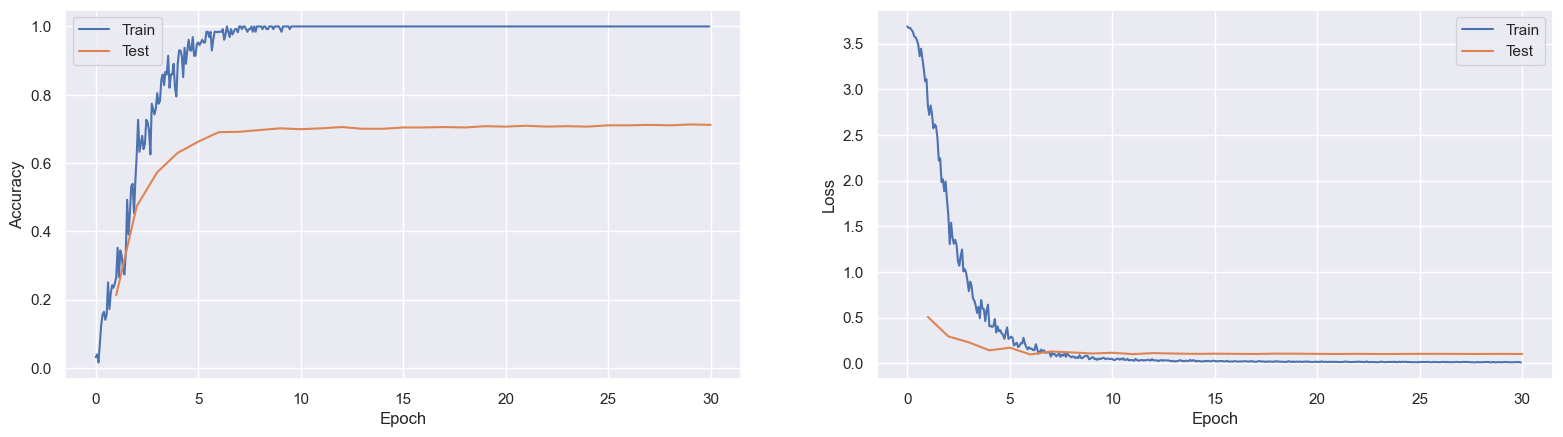

In [90]:
n_train = len(train_acc_history)
t_train = NUM_EPOCHS * np.arange(n_train) / n_train
t_test = np.arange(1, NUM_EPOCHS + 1)

plt.figure(figsize=(6.4 * 3, 4.8))
plt.subplot(1, 2, 1)
plt.plot(t_train, train_acc_history, label="Train")
plt.plot(t_test, test_acc_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_test, test_loss_history, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [91]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test_norm, dtype=torch.float))
    y_pred = [ohe.categories_[0][idx] for idx in torch.argmax(y_pred, 1)]

In [92]:
cf_matrix = confusion_matrix(y_test_speaker, y_pred)
cf_matrix

print('Confusion Matrix\n')
print(cf_matrix)

accuracy = accuracy_score(y_test_speaker, y_pred)

weighted_precision = precision_score(y_test_speaker, y_pred, average='weighted')
weighted_recall = recall_score(y_test_speaker, y_pred, average='weighted')
weighted_f1_score = f1_score(y_test_speaker, y_pred, average='weighted')

print('\nAccuracy: {:.3f}\n'.format(accuracy))

# Calculate metrics for each label, and find their average weighted by support 
print('Weighted Precision: {:.2f}'.format(weighted_precision))
print('Weighted Recall: {:.2f}'.format(weighted_recall))
print('Weighted F1-score: {:.2f}'.format(weighted_f1_score))

print('\nClassification Report\n')
print(classification_report(y_test_speaker, y_pred))

NNPT_multi_metrics = [accuracy, weighted_precision, weighted_recall, weighted_f1_score]

Confusion Matrix

[[11  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ... 19  0  0]
 [ 0  0  0 ...  0 22  0]
 [ 0  1  0 ...  3  0  2]]

Accuracy: 0.712

Weighted Precision: 0.72
Weighted Recall: 0.71
Weighted F1-score: 0.70

Classification Report

              precision    recall  f1-score   support

        84.0       1.00      0.58      0.73        19
       174.0       0.60      0.71      0.65        17
       251.0       0.60      0.55      0.57        22
       422.0       0.80      0.80      0.80        10
       652.0       0.95      0.90      0.93        21
       777.0       0.70      0.88      0.78        24
      1272.0       0.94      0.81      0.87        21
      1462.0       0.90      0.93      0.91        28
      1673.0       0.50      0.83      0.62        12
      1919.0       0.85      0.89      0.87        19
      1988.0       0.35      0.27      0.31        22
      1993.0       0.93      0.76      0.84        17
      2035

### Compare ML models

In [93]:
metrics_data = np.array([LR_multi_metrics, SVM_multi_metrics, RF_multi_metrics, NNSK_multi_metrics, NNPT_multi_metrics])

df = pd.DataFrame(metrics_data, columns=["Accuracy", "Precision", "Recall", "F1-Score"])
df.index = ['LR', 'SVM', 'RF', 'NN (SK)', 'NN (PT)']

with pd.option_context('display.precision', 3):
    display(df)

Accuracy  Precision  Recall  F1-Score
LR          0.741      0.756   0.741     0.733
SVM         0.699      0.721   0.699     0.692
RF          0.555      0.586   0.555     0.533
NN (SK)     0.724      0.733   0.724     0.715
NN (PT)     0.712      0.724   0.712     0.703

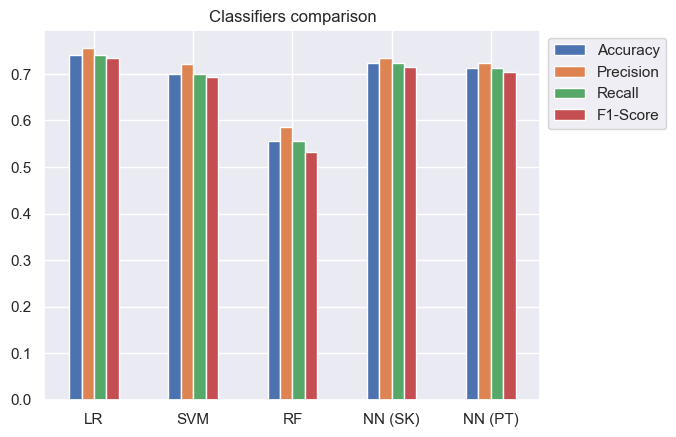

In [94]:
ax = df.plot.bar(rot=0)
ax.set_title("Classifiers comparison")
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

**Conclusion:** We can see that our multi-class classifiers do a bit less well than the previous binary classifiers (the max accuracy is now 74%). The Random Forest is the worse this time, probably because of the imbalanced classification. The best algorithm is the Multinomial Logistic Regression. The Neural Networks are also pretty good, with over 72% accuracy. They could probably be improved with more fine tuning.

## B. Qualitative analysis
In this section, we perform a qualitative analysis, by using algorithms of dimensionality reduction and clustering and visualizing the results.

#### PCA analysis

Since we a have extracted a high number of dimensions/features per observation (768), we will use Principal component analysis (PCA) to try to analyzing and interpret our dataset. \
We will use the first two principal components in order to plot the data in two dimensions and try to visually identify clusters of closely related data points.

In [95]:
# Reduce our dimensionality using Singular Value Decomposition project the data into to a 2 dimensional space. 
reduced_X_train = PCA(n_components=2).fit_transform(X_train_norm)
reduced_X_test = PCA(n_components=2).fit_transform(X_test_norm)

print(f"• Reduced train set: {reduced_X_train.shape[0]:,} samples, {reduced_X_train.shape[1]} dimensions")
print(f"• Reduced test set:  {reduced_X_test.shape[0]:,} samples, {reduced_X_test.shape[1]} dimensions")

• Reduced train set: 1,909 samples, 2 dimensions
• Reduced test set:  794 samples, 2 dimensions


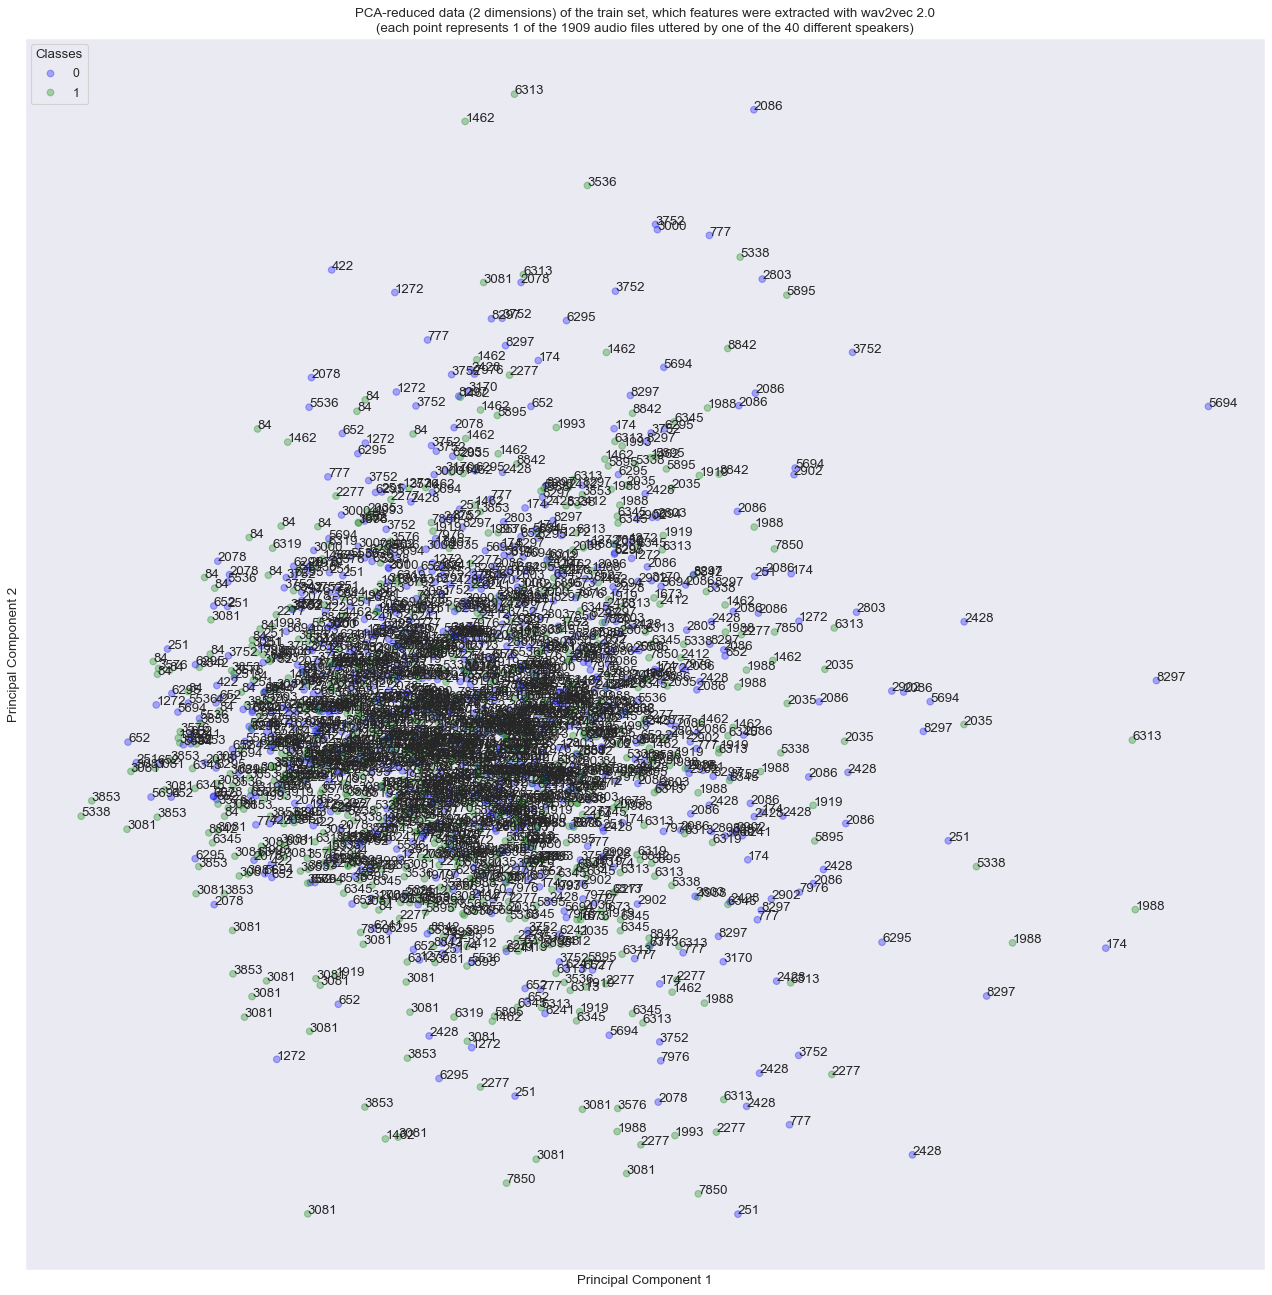

In [96]:
# plot the data in 2 dimentions

figure(figsize=(20, 20), dpi=80)

colors = ['blue','green']
scatter = plt.scatter(reduced_X_train[:, 0], reduced_X_train[:, 1], c=y_train_gender.ravel(), alpha=0.3, cmap=matplotlib.colors.ListedColormap(colors))

# annotate each point with its corresponding speaker number
for i, l in enumerate(y_train_speaker.ravel()):
    plt.annotate(int(l), (reduced_X_train[i, 0], reduced_X_train[i, 1]))
    
plt.legend(*scatter.legend_elements(),loc="upper left", title="Classes")

plt.title(
    f"PCA-reduced data (2 dimensions) of the train set, which features were extracted with wav2vec 2.0\n"
    f"(each point represents 1 of the {len(y_train_speaker)} audio files uttered by one of the {len(set(y_train_speaker.ravel()))} different speakers)"
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.xticks(())
plt.yticks(())
plt.show()

**Obervation:** Although it is a bit hard to see in the middle of the plot, we can detect a few clusters with the same speakers on the sides, for example:
- speaker 3081 in the lower left quadrant
- speaker 84 in the upper left quadrant
- speaker 2086 in the upper right quadrant

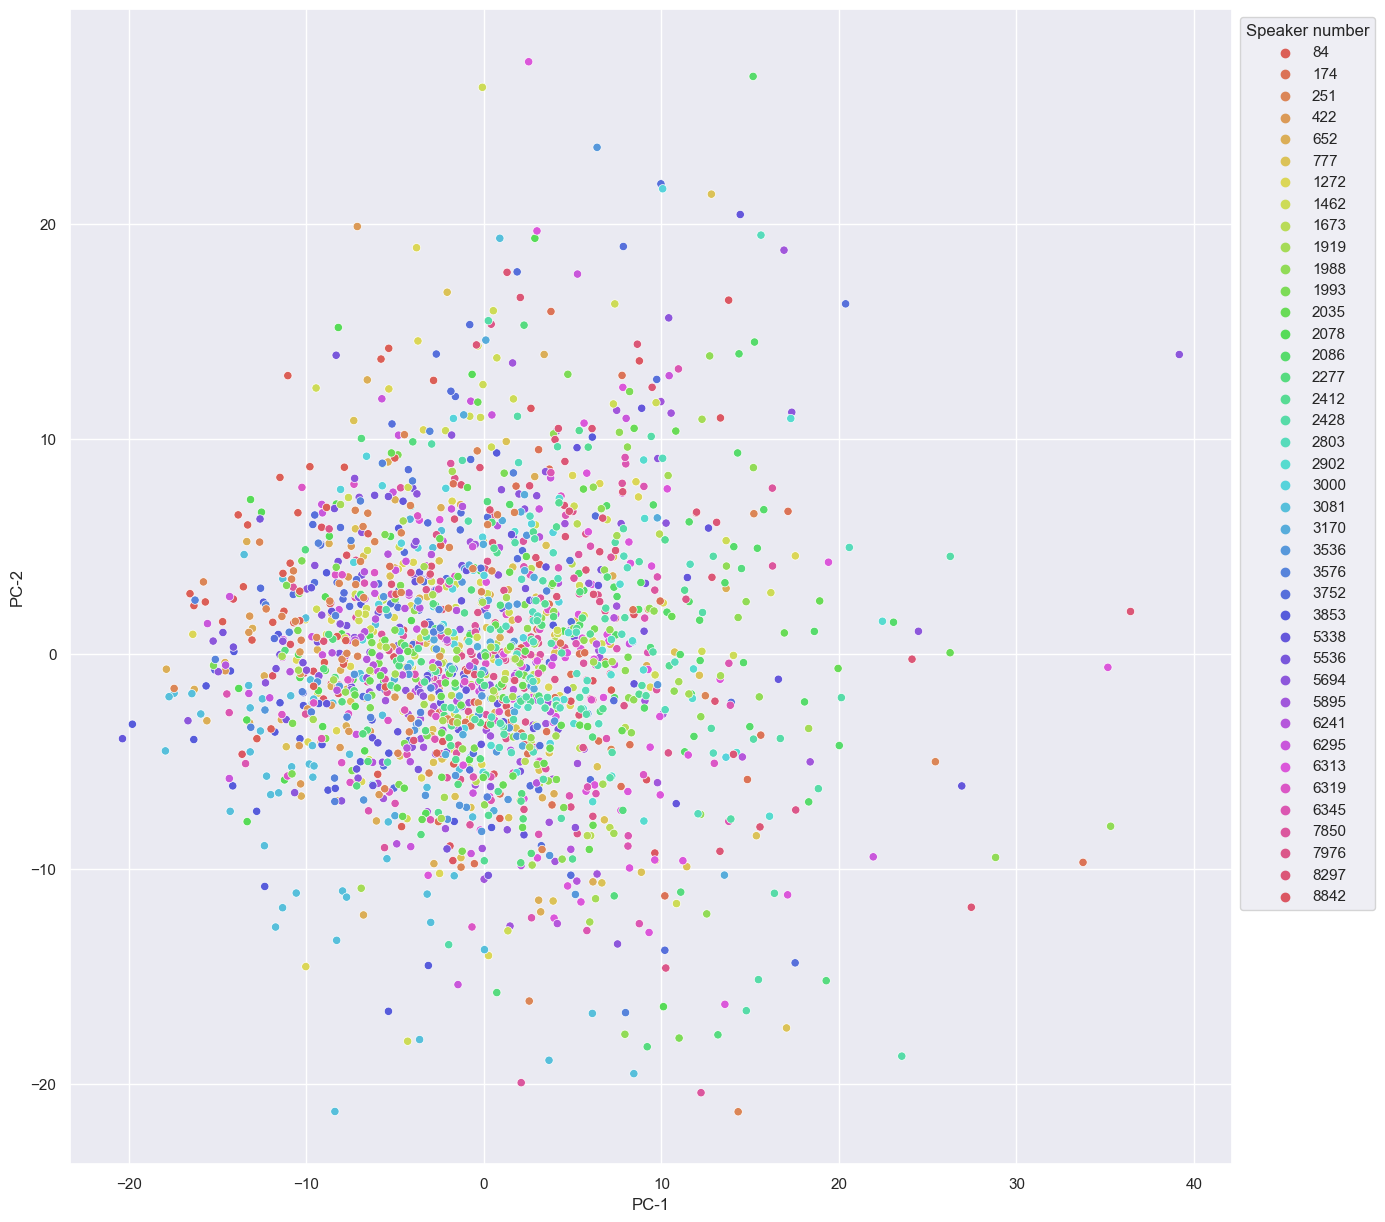

In [97]:
# same visualization but with colors instead of labels
fig, ax = plt.subplots(1,1, figsize=(15, 15),  sharey=False, sharex=False)

df = pd.DataFrame()

df["y_train_speaker"] = [int(y) for y in y_train_speaker.ravel()] 
df["PC-1"] = reduced_X_train[:,0]
df["PC-2"] = reduced_X_train[:,1]



sns.scatterplot(x="PC-1", y="PC-2", hue=df["y_train_speaker"],
                palette=sns.color_palette("hls", 40),
                data=df, ax=ax)
ax.legend(bbox_to_anchor=(1.0, 1.0), title="Speaker number")

plt.show()

In [98]:
# speakers of entire dataset
y_speaker = wav2vec_dataset[:, [-2]]
n_speakers = len(set(y_speaker.ravel()))
print(f"Number of speakers in whole dataset: {n_speakers}")

Number of speakers in whole dataset: 40


In [99]:
reduced_X_train = PCA(n_components=2).fit_transform(X_train_norm)
reduced_X_test = PCA(n_components=2).fit_transform(X_test_norm)

print(f"• Reduced train set: {reduced_X_train.shape[0]:,} samples, {reduced_X_train.shape[1]} dimensions")
print(f"• Reduced test set:  {reduced_X_test.shape[0]:,} samples, {reduced_X_test.shape[1]} dimensions")

• Reduced train set: 1,909 samples, 2 dimensions
• Reduced test set:  794 samples, 2 dimensions


In [100]:
# run K-means algorithm on reduced train set with 2 clusters (for male and female)
kmeans = KMeans(init="k-means++", n_clusters=40, n_init=2)
kmeans.fit(reduced_X_train)
kmeans.labels_

array([31, 31,  0, ..., 20,  5, 19], dtype=int32)

##### K-means clustering on PCA-reduced data

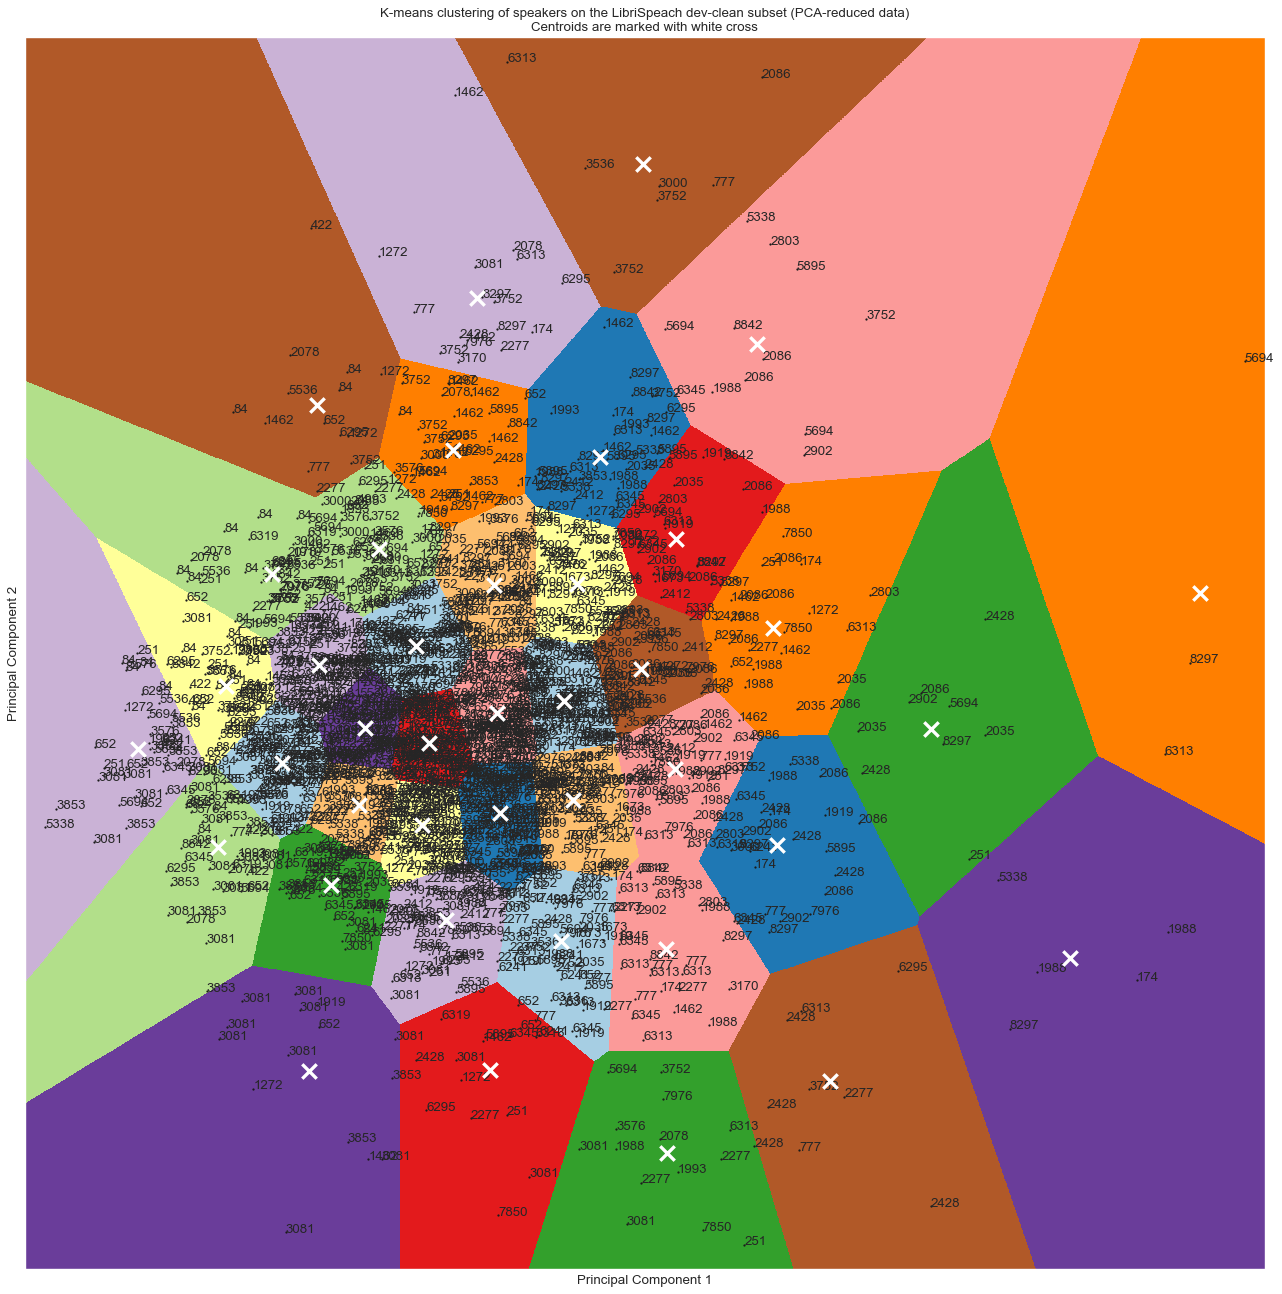

In [101]:
figure(figsize=(20, 20), dpi=80)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_X_train[:, 0].min() - 1, reduced_X_train[:, 0].max() + 1
y_min, y_max = reduced_X_train[:, 1].min() - 1, reduced_X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Paired, aspect="auto", origin="lower")
plt.plot(reduced_X_train[:, 0], reduced_X_train[:, 1], "k.", markersize=2)

# annotate each point with its corresponding speaker number
for i, l in enumerate(y_train_speaker.ravel()):
    plt.annotate(int(l), (reduced_X_train[i, 0], reduced_X_train[i, 1]))
    
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3, color="w", zorder=10)

plt.title(
    f"K-means clustering of speakers on the LibriSpeach dev-clean subset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.xticks(())
plt.yticks(())
plt.show()

#### t-SNE

t-distributed stochastic neighbor embedding is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space. In our case, we will project our data in 2 dimensions.

In [102]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X_train_norm) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1909 samples in 0.005s...
[t-SNE] Computed neighbors for 1909 samples in 0.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1909
[t-SNE] Computed conditional probabilities for sample 1909 / 1909
[t-SNE] Mean sigma: 7.186590
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.509254
[t-SNE] KL divergence after 1000 iterations: 2.292914


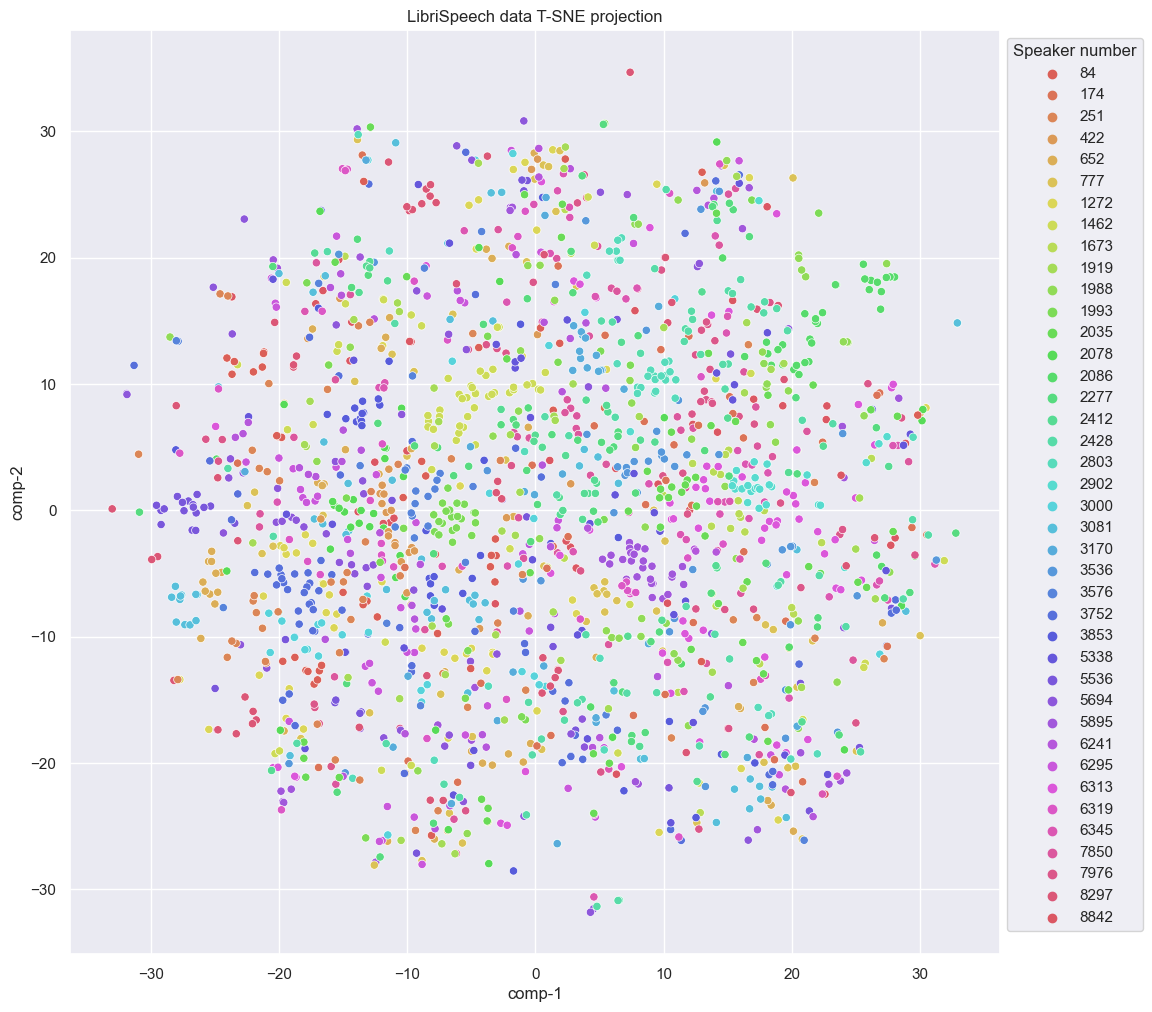

In [103]:
df = pd.DataFrame()
df["y_train_speaker"] = [int(y) for y in y_train_speaker.ravel()] 
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

fig, ax = plt.subplots(1,1, figsize=(12, 12),  sharey=False, sharex=False)

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y_train_speaker.tolist(),
                palette=sns.color_palette("hls", 40),
                data=df, ax=ax)
ax.set(title="LibriSpeech data T-SNE projection") 
ax.legend(bbox_to_anchor=(1.0, 1.0), title="Speaker number")

plt.show()

**Obervation:** With t-SNE, we can distinguish some clusters formed by same users (each represented by a color)

#### UMAP
UMAP is a general purpose manifold learning and dimension reduction algorithm.

In [104]:
reducer = umap.UMAP()

In [105]:
embedding = reducer.fit_transform(X_train_norm)
embedding.shape

(1909, 2)

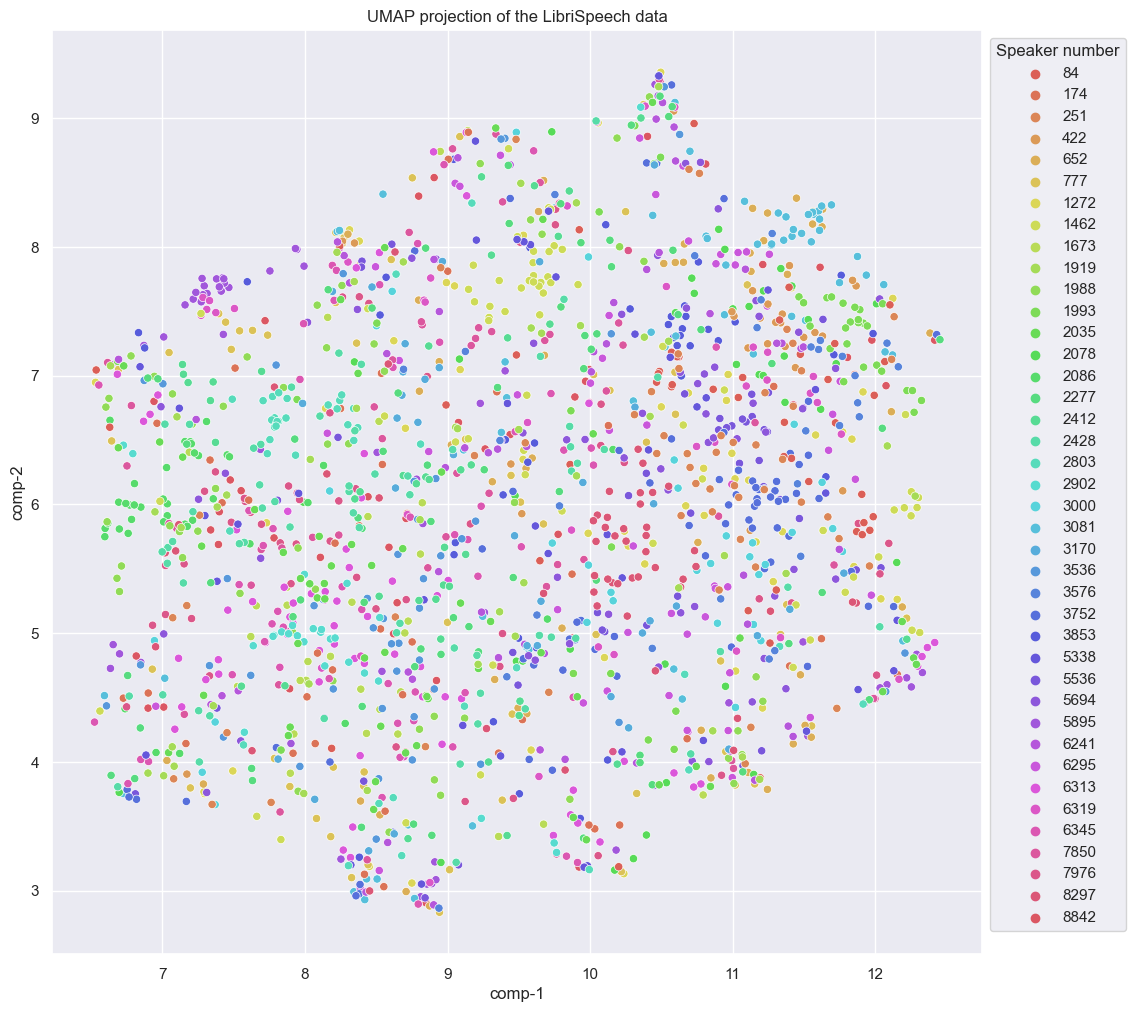

In [106]:
df = pd.DataFrame()
df["y_train_speaker"] = [int(y) for y in y_train_speaker.ravel()] 
df["comp-1"] = embedding[:, 0]
df["comp-2"] = embedding[:, 1]

fig, ax = plt.subplots(1,1, figsize=(12, 12),  sharey=False, sharex=False)

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y_train_speaker.tolist(),
                palette=sns.color_palette("hls", 40),
                data=df, ax=ax)
ax.set(title="UMAP projection of the LibriSpeech data") 
ax.legend(bbox_to_anchor=(1.0, 1.0), title="Speaker number")
plt.show()